# Predicción de Exitus (fallecimiento). Comparativa final

In [1]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd 
import multiprocessing
import random
from sklearn.metrics import roc_auc_score as metric




from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
import timeit

## Dataset

Leamos el dataset a utilizar.

In [2]:
# Load the dataset 
X = pd.read_csv("datasets/dat_sanidad.csv", sep=';', decimal=',', encoding='latin-1')
X.shape

(32706, 10)

El dataset consta de:

- 32706 **filas** o instancias
- 10 **columnas** o variables.

Veamos su contenido.

In [3]:
X.head()

,gravedad,pct_mortalidad_norma,edad_dias,numproc,potencial_ambul,proc,estancia_esperada,tipgrd,tiping,exitus
0,4,0.408730,12596,21,0,1,151,Q,1,0
1,4,0.306931,20973,22,0,1,99,Q,1,0
2,4,0.278481,19611,19,0,1,87,Q,1,0
3,3,0.150289,13583,22,0,1,100,Q,1,0
4,1,0.016573,18042,2,0,1,44,Q,1,0


- **gravedad**: Gravedad dentro del GRD. Valores de 1 a 4.

- **pct_mortalidad_norma**: Tasa de mortalidad histórica para ese GRD.
        
- **edad_dias**: Edad en días del paciente.

- **numproc**: Número de procedimientos que se han llevado a cabo al paciente a las 24 horas.
    
- **potencial_ambul**: Flag (valor 0 = no / 1 = sí) que indica si el caso se ha catalogado como potencialmente ambulatorio, es decir, no requiere ingreso.
    
- **proc**: Procedencia del paciente.

- **estancia_esperada**: Número de días que se espera que el paciente esté ingresado en el hospital por este episodio asistencial.

- **tipgrd**: GRD médico (M) o de quirófano (Q).
    
- **tiping**: Tipo de ingreso: Programado, urgente...
    
- **exitus**: 1 = El paciente falleció.

De estas variables, fecing la usaremos para realizar el split en train/validacion/test, exitus es el target y las 10 variables restantes serán el input de nuestro modelo.

## Pre-procesado

### One-Hot Encoding

Utilizaremos la técnica de one-hot encoding.

<img src="../figures/oh.png" width="50%">

Seleccionemos las variables categóricas en primer lugar.

In [4]:
categorical_vars = set(['gravedad', 'proc', 'tiping', 'tipgrd'])
numerical_vars = set(X.columns) - categorical_vars
categorical_vars = list(categorical_vars)
numerical_vars = list(numerical_vars)

In [5]:
print(categorical_vars)
print(numerical_vars)

['proc', 'tiping', 'gravedad', 'tipgrd']
['pct_mortalidad_norma', 'potencial_ambul', 'exitus', 'edad_dias', 'numproc', 'estancia_esperada']


Realizamos one hot encoding de las variables categoricas

In [6]:
ohe = OneHotEncoder(sparse = False)
ohe_fit = ohe.fit(X[categorical_vars])
X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_vars]))
X_ohe.columns = pd.DataFrame(ohe_fit.get_feature_names())


Volvemos a pegar las variables numéricas.

In [7]:
X = pd.concat((X_ohe, X[numerical_vars].reset_index()), axis=1)
del X['index']

### Tipificar

Ahora vamos a tipificar los datos, es decir, llevarlos a media 0 y desviación estándar 1.

<img src="../figures/tipify.png" width="50%">

In [8]:
y = X['exitus']
del X['exitus']

In [9]:
X_scale = pd.DataFrame(scale(X))
X_scale.columns = X.columns
X = X_scale
X.columns = X_scale.columns
print(X.head())

    (x0_1,)   (x0_2,)   (x0_3,)   (x0_4,)   (x0_6,)   (x0_7,)   (x0_8,)  \
0  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   
1  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   
2  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   
3  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   
4  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   

    (x0_9,)   (x1_1,)  (x1_2,)  ...   (x2_2,)   (x2_3,)   (x2_4,)   (x3_M,)  \
0 -0.090724  0.589285  -0.5681  ... -0.435743 -0.417921  4.120705 -1.554964   
1 -0.090724  0.589285  -0.5681  ... -0.435743 -0.417921  4.120705 -1.554964   
2 -0.090724  0.589285  -0.5681  ... -0.435743 -0.417921  4.120705 -1.554964   
3 -0.090724  0.589285  -0.5681  ... -0.435743  2.392797 -0.242677 -1.554964   
4 -0.090724  0.589285  -0.5681  ... -0.435743 -0.417921 -0.242677 -1.554964   

    (x3_Q,)  pct_mortalidad_norma  potencial_ambul  edad_dias   numproc  \

### Split en Train/Validación/Test

Utilizaremos a modo de ejemplo los ratios habitualmente recomendados:

• Train: 70%.

• Validación: 15%.

• Test: 15%.


In [10]:
perc_values = [0.7, 0.15, 0.15];

Creamos los conjuntos de train, validacion y test con el tamaño seleccionado pero respetando el eje temporal.

In [11]:
# dimensiones de los conjuntos de train y test
n_train = int(X.shape[0] * perc_values[0])
n_val = int(X.shape[0] * perc_values[1])
n_test = int(X.shape[0] * perc_values[2])

# selección del conjunto de train
X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]

# selección del conjunto de validación
X_val = X.iloc[(n_train):(n_train+n_val)]
y_val = y.iloc[(n_train):(n_train+n_val)]

# selección del conjunto de test
X_test = X.iloc[(n_train+n_val):]
y_test = y.iloc[(n_train+n_val):]

Visualizamos el tamaño de los 3 subdatasets

In [12]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))
print('Test data size = ' + str(X_test.shape))
print('Test target size = ' + str(y_test.shape))

Train data size = (22894, 22)
Train target size = (22894,)
Validation data size = (4905, 22)
Validation target size = (4905,)
Test data size = (4907, 22)
Test target size = (4907,)


# Grid Search

Vamos a proceder a realizar un grid search que compare todos los modelos de clasificación que hemos visto, es decir:

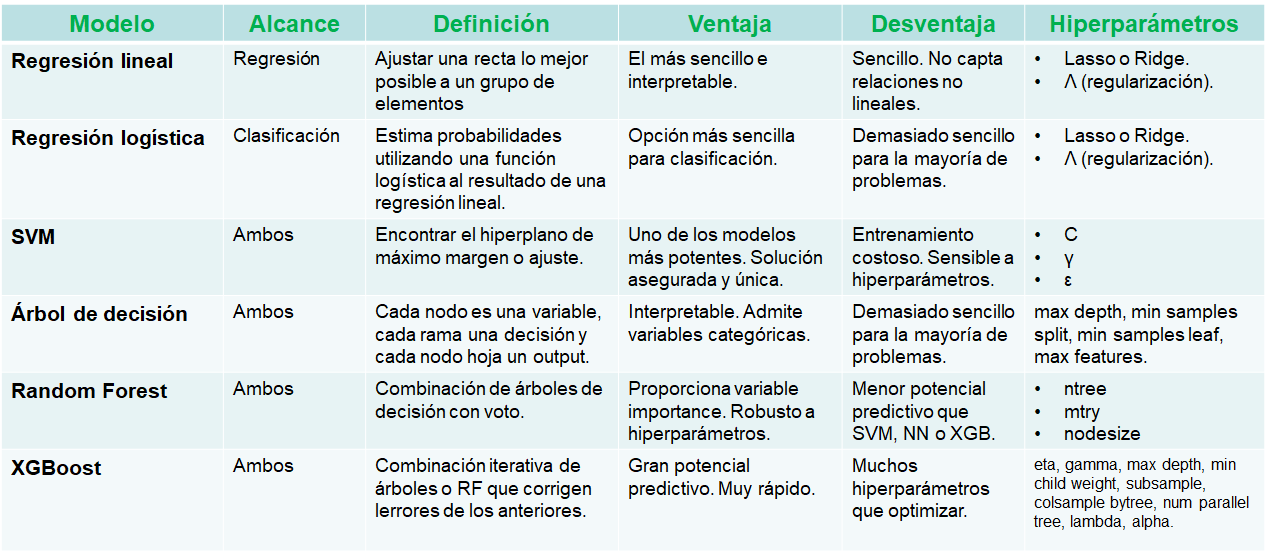

Importamos todos los modelos que vamos a usar.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

Importamos la métrica, en este caso AUC.

In [14]:
from sklearn.metrics import roc_auc_score as metric;

Definimos algunos parámetros generales.

In [15]:
random_state = 1;
nthread = multiprocessing.cpu_count() - 1;
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1);

Vamos a calcular los puntos recomendados por Cherkassky para la SVM.

In [16]:
n = X_train.shape[0];
d = X_train.shape[1];
m = np.mean(y_train);
s = np.std(y_train);
C_cherk = np.max([np.abs(m + 3*s),np.abs(m - 3*s)]);
gamma_cherk = np.power(0.2, 1/d)

Definimos el grid a llevar a cabo

In [17]:
# Regresion Logística
regularization_values = ['l1', 'l2', 'none'];
penalty_values = [1, 10, 100];

# SVM
C_values = [C_cherk, 5e-03, 4.5e-03, 4e-03];
gamma_kernel_values = [gamma_cherk, 3.26e-09, 3.255e-09, 3.25e-09];

# Arbol de Decision
max_depth_values = [None, 6, 20];
min_samples_split_values = [2, 5, 20];
min_samples_leaf_values = [1, 5, 20];
max_features_values = [None, 1, 2];

# Random Forest
ntrees_values = [10, 100, 1000];

# Xgboost
nrounds_values = [10, 100]
eta_values = [0.3, 0.99]
gamma_values = [0, 1]
max_depth_values = [6, 20]
min_child_weight_values = [1, 20]
subsample_values = [0.1, 1]
colsample_bytree_values = [0.1, 1]
num_parallel_tree_values = [1, 20]
lambda_values = [0, 1]
alpha_values = [0, 1]

In [18]:
params_values = [{'model': 'logistic regression',
                  'regularization': regularization_values,
                 'penalty': penalty_values},
                 {'model': 'svm',
                  'C': C_values,
                 'gamma_kernel': gamma_kernel_values},
                 {'model': 'decision tree',
                 'max_depth': max_depth_values,
                 'min_samples_split': min_samples_split_values,
                 'min_samples_leaf': min_samples_leaf_values,
                 'max_features': max_features_values},
                 {'model': 'random forest',
                  'n_trees': ntrees_values,
                 'max_depth': max_depth_values,
                 'min_samples_split': min_samples_split_values,
                 'min_samples_leaf': min_samples_leaf_values,
                 'max_features': max_features_values},
                 {'model': 'xgboost',
                  'nrounds': nrounds_values,
                  'eta': eta_values,
                 'gamma': gamma_values,
                 'max_depth': max_depth_values,
                 'min_child_weight': min_child_weight_values,
                 'subsample': subsample_values,
                 'colsample_bytree': colsample_bytree_values,
                 'num_parallel_tree': num_parallel_tree_values,
                 'lambda': lambda_values,
                 'alpha': alpha_values}]

In [19]:
total_iteraciones = 0
for params in params_values:
    if params['model'] == 'logistic regression':
        n = len(params['regularization'])*len(params['penalty'])
    elif params['model'] == 'svm':
        n = len(params['C'])*len(params['gamma_kernel'])
    elif params['model'] == 'decision tree':
        n = len(params['max_depth'])*len(params['min_samples_split'])*len(params['min_samples_leaf'])*len(params['max_features'])
    elif params['model'] == 'random forest':
        n = len(params['n_trees'])*len(params['max_depth'])*len(params['min_samples_split'])*len(params['min_samples_leaf'])*len(params['max_features'])
    elif params['model'] == 'xgboost':
        n = len(params['nrounds'])*len(params['eta'])*len(params['gamma'])*len(params['max_depth'])*len(params['min_child_weight'])*len(params['subsample'])*len(params['colsample_bytree'])*len(params['num_parallel_tree'])*len(params['lambda'])*len(params['alpha'])
    total_iteraciones = total_iteraciones + n;
    print(str(n)+ ' iteraciones de ' + str(params['model']))
print(str(total_iteraciones)+ ' iteraciones en total')        

9 iteraciones de logistic regression
16 iteraciones de svm
54 iteraciones de decision tree
162 iteraciones de random forest
1024 iteraciones de xgboost
1265 iteraciones en total


In [20]:
grid_results = pd.DataFrame();
num_iter = 0
for params in params_values:
    
    # Logistic Regression
    if params['model'] == 'logistic regression':
        for regularization in params['regularization']:
            for penalty in params['penalty']:  
                
                # Actualizar contador
                num_iter += 1; 
                
                # print control iteracion modelo
                print('Inicio de iteracion ' + str(num_iter) + 
                      '. Regularizacion = ' + str(regularization) + 
                      ', Lambda = '  + str(penalty) +
                      '\n')
                
                # Entrenar modelo
                if regularization == 'l1':
                    model = LogisticRegression(penalty = regularization, solver = 'liblinear', C = penalty, random_state = random_state)
                else:
                    model = LogisticRegression(penalty = regularization,solver = 'lbfgs', C = penalty, random_state = random_state)
               
                model.fit(X_train, np.array(y_train))

                # Generar predicciones
                pred_train_p = model.predict_proba(X_train)
                pred_val_p = model.predict_proba(X_val)

                # Calcular métricas de evaluación
                auc_train = metric(y_train, pred_train_p[:, 1])
                auc_val = metric(y_val, pred_val_p[:, 1])                                            

                print('Fin de iteracion ' + str(num_iter) + 
                     '. Regularizacion = ' + str(regularization) + 
                      ', Lambda = '  + str(penalty) +
                      '. AUC train = '  + str(auc_train) + 
                      ' -  AUC val = '  + str(auc_val)  + 
                      '\n')
                grid_results = grid_results.append(pd.DataFrame(data={'model':'Logistic Regression',
                                                                      'params': [{'regularization':[regularization],
                                                                                  'penalty':[penalty]}],
                                                                      'auc_train':[auc_train],
                                                                      'auc_val':[auc_val]},
                                                               columns=['model','params', 'auc_train', 'auc_val']), 
                                                   ignore_index=True)
                
     
    # SVM
    if params['model'] == 'svm':
        for C in params['C']:
            for gamma_kernel in params['gamma_kernel']:  
                
                # Actualizar contador
                num_iter += 1; 
                
                # print control iteracion modelo
                print('Inicio de iteracion ' + str(num_iter) + 
                      '. C = ' + str(C) + 
                      ', gamma = '  + str(gamma_kernel) +
                      '\n')
                
                # Entrenar modelo               
                model = SVC(C = C, gamma = gamma_kernel, probability = True, random_state = random_state)
               
                model.fit(X_train, np.array(y_train))

                # Generar predicciones
                pred_train_p = model.predict_proba(X_train)
                pred_val_p = model.predict_proba(X_val)

                # Calcular métricas de evaluación
                auc_train = metric(y_train, pred_train_p[:, 1])
                auc_val = metric(y_val, pred_val_p[:, 1])                                            

                print('Fin de iteracion ' + str(num_iter) + 
                     '. C = ' + str(C) + 
                      ', gamma = '  + str(gamma_kernel) +
                      '. AUC train = '  + str(auc_train) + 
                      ' -  AUC val = '  + str(auc_val)  + 
                      '\n')
                grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
                                                                     'params': [{'C':[C],
                                                                              'gamma_kernel':[gamma_kernel]}],
                                                                      'auc_train':[auc_train],
                                                                      'auc_val':[auc_val]},
                                                               columns=['model','params', 'auc_train', 'auc_val']), 
                                                   ignore_index=True)
                
    # Decision Tree
    if params['model'] == 'decision tree':
        for max_depth in params['max_depth']:
            for min_samples_split in params['min_samples_split']:  
                for min_samples_leaf in params['min_samples_leaf']:  
                    for max_features in params['max_features']:  
                
                        # Actualizar contador
                        num_iter += 1; 

                        # print control iteracion modelo
                        print('Inicio de iteracion ' + str(num_iter) + 
                              '. max_depth = ' + str(max_depth) + 
                              ', min_samples_split = '  + str(min_samples_split) +
                              ', min_samples_leaf = '  + str(min_samples_leaf) +
                              ', max_features = '  + str(max_features) +
                              '\n')

                        # Entrenar modelo               
                        model = DecisionTreeClassifier(max_depth = max_depth,
                                                      min_samples_split = min_samples_split,
                                                      min_samples_leaf = min_samples_leaf,
                                                      max_features = max_features, random_state = random_state)

                        model.fit(X_train, np.array(y_train))

                        # Generar predicciones
                        pred_train_p = model.predict_proba(X_train)
                        pred_val_p = model.predict_proba(X_val)

                        # Calcular métricas de evaluación
                        auc_train = metric(y_train, pred_train_p[:, 1])
                        auc_val = metric(y_val, pred_val_p[:, 1])                                            

                        print('Fin de iteracion ' + str(num_iter) + 
                             '. max_depth = ' + str(max_depth) + 
                              ', min_samples_split = '  + str(min_samples_split) +
                              ', min_samples_leaf = '  + str(min_samples_leaf) +
                              ', max_features = '  + str(max_features) +
                              '. AUC train = '  + str(auc_train) + 
                              ' -  AUC val = '  + str(auc_val)  + 
                              '\n')
                        grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
                                                                              'params': [{'max_depth':[max_depth],
                                                                                          'min_samples_split':[min_samples_split],
                                                                                          'min_samples_leaf':[min_samples_leaf],
                                                                                          'max_features':[max_features]}],
                                                                      'auc_train':[auc_train],
                                                                      'auc_val':[auc_val]},
                                                                       columns=['model','params', 'auc_train', 'auc_val']), 
                                                           ignore_index=True)  
                        
    
    # Random Forest
    if params['model'] == 'random forest':
        for n_trees in params['n_trees']:
            for max_depth in params['max_depth']:
                for min_samples_split in params['min_samples_split']:  
                    for min_samples_leaf in params['min_samples_leaf']:  
                        for max_features in params['max_features']:  
                
                            # Actualizar contador
                            num_iter += 1; 

                            # print control iteracion modelo
                            print('Inicio de iteracion ' + str(num_iter) + 
                                  '. n_trees = ' + str(n_trees) + 
                                  ', max_depth = ' + str(max_depth) + 
                                  ', min_samples_split = '  + str(min_samples_split) +
                                  ', min_samples_leaf = '  + str(min_samples_leaf) +
                                  ', max_features = '  + str(max_features) +
                                  '\n')

                            # Entrenar modelo               
                            model = RandomForestClassifier(n_estimators = n_trees,
                                                          max_depth = max_depth,
                                                          min_samples_split = min_samples_split,
                                                          min_samples_leaf = min_samples_leaf,
                                                          max_features = max_features, random_state = random_state)

                            model.fit(X_train, np.array(y_train))

                            # Generar predicciones
                            pred_train_p = model.predict_proba(X_train)
                            pred_val_p = model.predict_proba(X_val)

                            # Calcular métricas de evaluación
                            auc_train = metric(y_train, pred_train_p[:, 1])
                            auc_val = metric(y_val, pred_val_p[:, 1])                                            

                            print('Fin de iteracion ' + str(num_iter) + 
                                 '. n_trees = ' + str(n_trees) + 
                                  ', max_depth = ' + str(max_depth) + 
                                  ', min_samples_split = '  + str(min_samples_split) +
                                  ', min_samples_leaf = '  + str(min_samples_leaf) +
                                  ', max_features = '  + str(max_features) +
                                  '. AUC train = '  + str(auc_train) + 
                                  ' -  AUC val = '  + str(auc_val)  + 
                                  '\n')
                            grid_results = grid_results.append(pd.DataFrame(data={'model':'random forest',
                                                                                  'params': [{'n_trees':[n_trees],
                                                                                              'max_depth':[max_depth],
                                                                                              'min_samples_split':[min_samples_split],
                                                                                              'min_samples_leaf':[min_samples_leaf],
                                                                                              'max_features':[max_features]}],
                                                                          'auc_train':[auc_train],
                                                                          'auc_val':[auc_val]},
                                                                           columns=['model','params', 'auc_train', 'auc_val']), 
                                                               ignore_index=True)  
    
    # XGBOOST
    if params['model'] == 'xgboost':
         for nrounds in params['nrounds']:
            for eta in params['eta']:
                for gamma in params['gamma']:
                    for max_depth in params['max_depth']:
                        for min_child_weight in params['min_child_weight']:
                            for subsample in params['subsample']:
                                for colsample_bytree in params['colsample_bytree']:
                                    for num_parallel_tree in params['num_parallel_tree']:
                                        for lamda in params['lambda']:
                                            for alpha in params['alpha']:
                                            
                                                # Actualizar contador
                                                num_iter += 1; 

                                                # print control iteracion modelo
                                                print('Inicio de iteracion ' + str(num_iter) + 
                                                      '. Parametro nrounds = ' + str(nrounds) + 
                                                      ', parametro eta = '  + str(eta) +
                                                      ', parametro gamma = '  + str(gamma) +
                                                      ', parametro max_depth = '  + str(max_depth) +
                                                      ', parametro min_child_weight = '  + str(min_child_weight) +
                                                      ', parametro subsample = '  + str(subsample) +
                                                      ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                                      ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                                      ', parametro lambda = '  + str(lamda) +
                                                      ', parametro alpha = '  + str(alpha) + 
                                                      '\n')
                                                # Entrenar modelo
                                                model = XGBClassifier(nthread = nthread, 
                                                                      scale_pos_weight = scale_pos_weight,
                                                                      random_state = random_state,
                                                                      n_estimators = nrounds,
                                                                      learning_rate = eta, 
                                                                      gamma = gamma,
                                                                      max_depth = max_depth,
                                                                      min_child_weight = min_child_weight ,
                                                                      subsample = subsample,
                                                                      colsample_bytree = colsample_bytree,
                                                                      num_parallel_tree = num_parallel_tree,
                                                                      reg_lambda = lamda,
                                                                      reg_alpha = alpha)
                                                model.fit(X_train, np.array(y_train))

                                                # Generar predicciones
                                                pred_train_p = model.predict_proba(X_train)
                                                pred_val_p = model.predict_proba(X_val)

                                                # Calcular métricas de evaluación
                                                auc_train = metric(y_train, pred_train_p[:, 1])
                                                auc_val = metric(y_val, pred_val_p[:, 1])                                            

                                                print('Fin de iteracion ' + str(num_iter) + 
                                                      '. Parametro nrounds = ' + str(nrounds) + 
                                                      ', parametro eta = ' + str(eta) + 
                                                      ', parametro gamma = '  + str(gamma) +
                                                      ', parametro max_depth = '  + str(max_depth) +
                                                      ', parametro min_child_weight = '  + str(min_child_weight) +
                                                      ', parametro subsample = '  + str(subsample) +
                                                      ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                                      ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                                      ', parametro lambda = '  + str(lamda) +
                                                      ', parametro alpha = '  + str(alpha) + 
                                                      '. AUC train = '  + str(auc_train) + 
                                                      ' -  AUC val = '  + str(auc_val)  + 
                                                      '\n')
                                                grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
                                                                                              'params': [{'nrounds':[nrounds],
                                                                                              'eta':[eta],
                                                                                              'gamma':[gamma],
                                                                                              'max_depth':[max_depth],
                                                                                              'min_child_weight':[min_child_weight],
                                                                                              'subsample':[subsample],
                                                                                              'colsample_bytree':[colsample_bytree],
                                                                                              'num_parallel_tree':[num_parallel_tree],
                                                                                              'lamda':[lamda],
                                                                                              'alpha':[alpha]}],
                                                                                              'auc_train':[auc_train],
                                                                                              'auc_val':[auc_val]},
                                                                                               columns=['model', 'params', 'auc_train', 'auc_val']), 
                                                                                   ignore_index=True)
                               


Inicio de iteracion 1. Regularizacion = l1, Lambda = 1

Fin de iteracion 1. Regularizacion = l1, Lambda = 1. AUC train = 0.9405732580379932 -  AUC val = 0.9380497022446176

Inicio de iteracion 2. Regularizacion = l1, Lambda = 10

Fin de iteracion 2. Regularizacion = l1, Lambda = 10. AUC train = 0.9405197616896837 -  AUC val = 0.9379363261566651

Inicio de iteracion 3. Regularizacion = l1, Lambda = 100

Fin de iteracion 3. Regularizacion = l1, Lambda = 100. AUC train = 0.9405132928414237 -  AUC val = 0.9377989005955107

Inicio de iteracion 4. Regularizacion = l2, Lambda = 1

Fin de iteracion 4. Regularizacion = l2, Lambda = 1. AUC train = 0.9405310051640405 -  AUC val = 0.9384264773247823

Inicio de iteracion 5. Regularizacion = l2, Lambda = 10

Fin de iteracion 5. Regularizacion = l2, Lambda = 10. AUC train = 0.9405154491241771 -  AUC val = 0.9389509848831882

Inicio de iteracion 6. Regularizacion = l2, Lambda = 100

Fin de iteracion 6. Regularizacion = l2, Lambda = 100. AUC train = 0.

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Fin de iteracion 7. Regularizacion = none, Lambda = 1. AUC train = 0.940510931198408 -  AUC val = 0.9388811268896015

Inicio de iteracion 8. Regularizacion = none, Lambda = 10



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Fin de iteracion 8. Regularizacion = none, Lambda = 10. AUC train = 0.940510931198408 -  AUC val = 0.9388811268896015

Inicio de iteracion 9. Regularizacion = none, Lambda = 100



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fin de iteracion 9. Regularizacion = none, Lambda = 100. AUC train = 0.940510931198408 -  AUC val = 0.9388811268896015

Inicio de iteracion 10. C = 0.6169806179118057, gamma = 0.9294555738186685

Fin de iteracion 10. C = 0.6169806179118057, gamma = 0.9294555738186685. AUC train = 0.888444763095118 -  AUC val = 0.719701672010994

Inicio de iteracion 11. C = 0.6169806179118057, gamma = 3.26e-09

Fin de iteracion 11. C = 0.6169806179118057, gamma = 3.26e-09. AUC train = 0.9381199730053935 -  AUC val = 0.9378458543289052

Inicio de iteracion 12. C = 0.6169806179118057, gamma = 3.255e-09

Fin de iteracion 12. C = 0.6169806179118057, gamma = 3.255e-09. AUC train = 0.9387003724465056 -  AUC val = 0.9385822262940907

Inicio de iteracion 13. C = 0.6169806179118057, gamma = 3.25e-09

Fin de iteracion 13. C = 0.6169806179118057, gamma = 3.25e-09. AUC train = 0.938591120787002 -  AUC val = 0.938858222629409

Inicio de iteracion 14. C = 0.005, gamma = 0.9294555738186685

Fin de iteracion 14. C = 0.

Inicio de iteracion 50. max_depth = 6, min_samples_split = 20, min_samples_leaf = 20, max_features = None

Fin de iteracion 50. max_depth = 6, min_samples_split = 20, min_samples_leaf = 20, max_features = None. AUC train = 0.9519405132928415 -  AUC val = 0.9373505497022447

Inicio de iteracion 51. max_depth = 6, min_samples_split = 20, min_samples_leaf = 20, max_features = 1

Fin de iteracion 51. max_depth = 6, min_samples_split = 20, min_samples_leaf = 20, max_features = 1. AUC train = 0.9114236266468289 -  AUC val = 0.9061114292258359

Inicio de iteracion 52. max_depth = 6, min_samples_split = 20, min_samples_leaf = 20, max_features = 2

Fin de iteracion 52. max_depth = 6, min_samples_split = 20, min_samples_leaf = 20, max_features = 2. AUC train = 0.9249330974770722 -  AUC val = 0.9184986257443886

Inicio de iteracion 53. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = None

Fin de iteracion 53. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1,

Fin de iteracion 80. n_trees = 10, max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.960114929870754 -  AUC val = 0.9379002519468621

Inicio de iteracion 81. n_trees = 10, max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 1

Fin de iteracion 81. n_trees = 10, max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 1. AUC train = 0.9420210222166434 -  AUC val = 0.9294691937700412

Inicio de iteracion 82. n_trees = 10, max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 2

Fin de iteracion 82. n_trees = 10, max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 2. AUC train = 0.9493552586217296 -  AUC val = 0.9374524736601009

Inicio de iteracion 83. n_trees = 10, max_depth = 6, min_samples_split = 2, min_samples_leaf = 5, max_features = None

Fin de iteracion 83. n_trees = 10, max_depth = 6, min_samples_split = 2, min_samples_leaf = 5, max_features = None. 

Fin de iteracion 109. n_trees = 10, max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 2. AUC train = 0.9993278558617391 -  AUC val = 0.8772366010077876

Inicio de iteracion 110. n_trees = 10, max_depth = 20, min_samples_split = 2, min_samples_leaf = 5, max_features = None

Fin de iteracion 110. n_trees = 10, max_depth = 20, min_samples_split = 2, min_samples_leaf = 5, max_features = None. AUC train = 0.9882631476132132 -  AUC val = 0.9251706367384332

Inicio de iteracion 111. n_trees = 10, max_depth = 20, min_samples_split = 2, min_samples_leaf = 5, max_features = 1

Fin de iteracion 111. n_trees = 10, max_depth = 20, min_samples_split = 2, min_samples_leaf = 5, max_features = 1. AUC train = 0.9773075626740267 -  AUC val = 0.9362946633073751

Inicio de iteracion 112. n_trees = 10, max_depth = 20, min_samples_split = 2, min_samples_leaf = 5, max_features = 2

Fin de iteracion 112. n_trees = 10, max_depth = 20, min_samples_split = 2, min_samples_leaf = 5, max_fe

Fin de iteracion 137. n_trees = 100, max_depth = 6, min_samples_split = 2, min_samples_leaf = 5, max_features = None. AUC train = 0.9612166106674901 -  AUC val = 0.9422526339899221

Inicio de iteracion 138. n_trees = 100, max_depth = 6, min_samples_split = 2, min_samples_leaf = 5, max_features = 1

Fin de iteracion 138. n_trees = 100, max_depth = 6, min_samples_split = 2, min_samples_leaf = 5, max_features = 1. AUC train = 0.9472261090930187 -  AUC val = 0.9334070087036189

Inicio de iteracion 139. n_trees = 100, max_depth = 6, min_samples_split = 2, min_samples_leaf = 5, max_features = 2

Fin de iteracion 139. n_trees = 100, max_depth = 6, min_samples_split = 2, min_samples_leaf = 5, max_features = 2. AUC train = 0.9501498231463091 -  AUC val = 0.9375475263398991

Inicio de iteracion 140. n_trees = 100, max_depth = 6, min_samples_split = 2, min_samples_leaf = 20, max_features = None

Fin de iteracion 140. n_trees = 100, max_depth = 6, min_samples_split = 2, min_samples_leaf = 20, max_

Fin de iteracion 165. n_trees = 100, max_depth = 20, min_samples_split = 2, min_samples_leaf = 5, max_features = 1. AUC train = 0.9810003765793809 -  AUC val = 0.9431029546495646

Inicio de iteracion 166. n_trees = 100, max_depth = 20, min_samples_split = 2, min_samples_leaf = 5, max_features = 2

Fin de iteracion 166. n_trees = 100, max_depth = 20, min_samples_split = 2, min_samples_leaf = 5, max_features = 2. AUC train = 0.9808429679383857 -  AUC val = 0.942882501145213

Inicio de iteracion 167. n_trees = 100, max_depth = 20, min_samples_split = 2, min_samples_leaf = 20, max_features = None

Fin de iteracion 167. n_trees = 100, max_depth = 20, min_samples_split = 2, min_samples_leaf = 20, max_features = None. AUC train = 0.9701867982615227 -  AUC val = 0.942246907924874

Inicio de iteracion 168. n_trees = 100, max_depth = 20, min_samples_split = 2, min_samples_leaf = 20, max_features = 1

Fin de iteracion 168. n_trees = 100, max_depth = 20, min_samples_split = 2, min_samples_leaf = 2

Fin de iteracion 193. n_trees = 1000, max_depth = 6, min_samples_split = 2, min_samples_leaf = 5, max_features = 2. AUC train = 0.9495971730106302 -  AUC val = 0.936464154832799

Inicio de iteracion 194. n_trees = 1000, max_depth = 6, min_samples_split = 2, min_samples_leaf = 20, max_features = None

Fin de iteracion 194. n_trees = 1000, max_depth = 6, min_samples_split = 2, min_samples_leaf = 20, max_features = None. AUC train = 0.9582579340295561 -  AUC val = 0.9430937929454878

Inicio de iteracion 195. n_trees = 1000, max_depth = 6, min_samples_split = 2, min_samples_leaf = 20, max_features = 1

Fin de iteracion 195. n_trees = 1000, max_depth = 6, min_samples_split = 2, min_samples_leaf = 20, max_features = 1. AUC train = 0.9447435858930848 -  AUC val = 0.933400710032066

Inicio de iteracion 196. n_trees = 1000, max_depth = 6, min_samples_split = 2, min_samples_leaf = 20, max_features = 2

Fin de iteracion 196. n_trees = 1000, max_depth = 6, min_samples_split = 2, min_samples_leaf =

Fin de iteracion 221. n_trees = 1000, max_depth = 20, min_samples_split = 2, min_samples_leaf = 20, max_features = None. AUC train = 0.9703720075480164 -  AUC val = 0.9427187356848375

Inicio de iteracion 222. n_trees = 1000, max_depth = 20, min_samples_split = 2, min_samples_leaf = 20, max_features = 1

Fin de iteracion 222. n_trees = 1000, max_depth = 20, min_samples_split = 2, min_samples_leaf = 20, max_features = 1. AUC train = 0.9584188081249762 -  AUC val = 0.9407077416399451

Inicio de iteracion 223. n_trees = 1000, max_depth = 20, min_samples_split = 2, min_samples_leaf = 20, max_features = 2

Fin de iteracion 223. n_trees = 1000, max_depth = 20, min_samples_split = 2, min_samples_leaf = 20, max_features = 2. AUC train = 0.9582027177890504 -  AUC val = 0.9406459001374256

Inicio de iteracion 224. n_trees = 1000, max_depth = 20, min_samples_split = 5, min_samples_leaf = 1, max_features = None

Fin de iteracion 224. n_trees = 1000, max_depth = 20, min_samples_split = 5, min_sampl

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Fin de iteracion 244. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9220639835835006 -  AUC val = 0.9216639945029774

Inicio de iteracion 245. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:39:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 245. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 246. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9371681281899829 -  AUC val = 0.9243810123683005

Inicio de iteracion 247. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:39:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 247. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9381614044382973 -  AUC val = 0.9263599404489233

Inicio de iteracion 248. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:39:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 248. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.938078284872162 -  AUC val = 0.9256430371049016

Inicio de iteracion 249. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:39:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 249. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9381806312928481 -  AUC val = 0.9269302565277142

Inicio de iteracion 250. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:39:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 250. Parametro nrounds = 10, parametro eta 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 252. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:39:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 252. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9439142898141567 -  AUC val = 0.9307672927164453

Inicio de iteracion 253. Parametro nrounds = 10, parametro eta 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 254. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:39:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 254. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9524656708234152 -  AUC val = 0.9385318369216674

Inicio de iteracion 255. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:39:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 255. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9527254772251619 -  AUC val = 0.9387477095739808

Inicio de iteracion 256. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:39:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 256. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9530496127290504 -  AUC val = 0.9405617269812185

Inicio de iteracion 257. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:39:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 257. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9532038639560139 -  AUC val = 0.9408503206596426

Inicio de iteracion 258. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:39:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 258. Parametro nrounds = 10, parametro eta = 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Fin de iteracion 261. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9309342890799938 -  AUC val = 0.9110896701786533

Inicio de iteracion 262. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:39:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 262. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9385624216903563 -  AUC val = 0.9210627576729272

Inicio de iteracion 263. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:39:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 263. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9380002993125822 -  AUC val = 0.9215895556573522

Inicio de iteracion 264. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:39:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 264. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.937992932013175 -  AUC val = 0.9216210490151168

Inicio de iteracion 265. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:39:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 265. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9375984092794087 -  AUC val = 0.9220699725148878

Inicio de iteracion 266. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:39:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 266. Parametro nrounds = 10, parametro eta = 0.

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 267. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.966389738353057 -  AUC val = 0.9398837608795236

Inicio de iteracion 268. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:39:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 268. Parametro nrounds = 10, parametro eta = 0.3, p

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 269. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9657414673452797 -  AUC val = 0.9412070545121394

Inicio de iteracion 270. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:39:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 270. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9670344925663436 -  AUC val = 0.9380915025194688

Inicio de iteracion 271. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:39:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 271. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.966389738353057 -  AUC val = 0.9398837608795236

Inicio de iteracion 272. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:39:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 272. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9660354148906214 -  AUC val = 0.9415139715987173

Inicio de iteracion 273. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:39:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 273. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9657414673452797 -  AUC val = 0.9412070545121394

Inicio de iteracion 274. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:39:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 274. Parametro nrounds = 10, parametro eta =

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Fin de iteracion 276. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9297747480293759 -  AUC val = 0.9213920064131929

Inicio de iteracion 277. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:39:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 277. Parametro nrounds = 10, parametro e

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 278. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9379153828441524 -  AUC val = 0.9279197205680256

Inicio de iteracion 279. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:39:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 279. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9378678676134802 -  AUC val = 0.928033096655978

Inicio de iteracion 280. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:39:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 280. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9378923824947831 -  AUC val = 0.92793689876317

Inicio de iteracion 281. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:39:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 281. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9375664500886001 -  AUC val = 0.9279174301420064

Inicio de iteracion 282. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:39:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 282. Parametro nrounds = 10, parametro et

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 284. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:39:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 284. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9467263392248626 -  AUC val = 0.933903458543289

Inicio de iteracion 285. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 286. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:39:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 286. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9527668829880329 -  AUC val = 0.9424478928080623

Inicio de iteracion 287. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:39:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 287. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9526500843388928 -  AUC val = 0.9427204535043519

Inicio de iteracion 288. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:39:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 288. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9527175965250989 -  AUC val = 0.9426860971140633

Inicio de iteracion 289. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:39:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 289. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9523160658723845 -  AUC val = 0.9427559551076501

Inicio de iteracion 290. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:39:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 290. Parametro nrounds = 10, parametro eta 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 293. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:39:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 293. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9300522667537394 -  AUC val = 0.9121152084287677

Inicio de iteracion 294. Parametro nrounds = 10, parametro et

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 294. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9367497836657988 -  AUC val = 0.9222995877233167

Inicio de iteracion 295. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:39:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 295. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9365126182329622 -  AUC val = 0.9223843334860284

Inicio de iteracion 296. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:39:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 296. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9365185223405013 -  AUC val = 0.9223797526339899

Inicio de iteracion 297. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:39:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 297. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9362046035096583 -  AUC val = 0.9223396701786533

Inicio de iteracion 298. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:39:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 298. Parametro nrounds = 10, parametro eta = 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 299. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9628452715671272 -  AUC val = 0.9448390975721486

Inicio de iteracion 300. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:39:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 300. Parametro nrounds = 10, parametro eta = 0.3

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 301. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9623514571465754 -  AUC val = 0.9449639257901971

Inicio de iteracion 302. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:39:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 302. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9624614275669967 -  AUC val = 0.9447428996793403

Inicio de iteracion 303. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:39:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 303. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9628452715671272 -  AUC val = 0.9448390975721486

Inicio de iteracion 304. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:39:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 304. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9626880939564273 -  AUC val = 0.9454025423728815

Inicio de iteracion 305. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:39:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 305. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9623514571465757 -  AUC val = 0.9449639257901971

Inicio de iteracion 306. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:39:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 306. Parametro nrounds = 10, parametro eta 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Fin de iteracion 308. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9261314002771851 -  AUC val = 0.9094892349977096

Inicio de iteracion 309. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:39:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 309. Parametro nrounds = 10, parametro e

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 310. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9423790935038645 -  AUC val = 0.9197537792029318

Inicio de iteracion 311. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:39:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 311. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9437172979826178 -  AUC val = 0.926015231333028

Inicio de iteracion 312. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:39:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 312. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9438237772785811 -  AUC val = 0.9253120705451214

Inicio de iteracion 313. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:39:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 313. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9426695755947812 -  AUC val = 0.9281487631699495

Inicio de iteracion 314. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:39:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 314. Parametro nrounds = 10, parametro et

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 315. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:39:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 315. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.941272817771261 -  AUC val = 0.8981018094365553

Inicio de iteracion 316. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 316. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9450793242517891 -  AUC val = 0.9003687585890975

Inicio de iteracion 317. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:39:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 317. Parametro nrounds = 10, parametro eta =

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:39:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 318. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9784201275646609 -  AUC val = 0.9362998167659186

Inicio de iteracion 319. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:39:58] WARNING: C:/Users/Administrator/workspace/xgboos

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 319. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9712719475571497 -  AUC val = 0.9403464269354099

Inicio de iteracion 320. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:40:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 320. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9713078342629737 -  AUC val = 0.9398986486486487

Inicio de iteracion 321. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:40:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 321. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9660795160069341 -  AUC val = 0.9412328218048558

Inicio de iteracion 322. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:40:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 322. Parametro nrounds = 10, parametro eta 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 325. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:40:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 325. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9351631446098193 -  AUC val = 0.9075143151626202

Inicio de iteracion 326. Parametro nrounds = 10, parametro et

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 326. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9838989596705816 -  AUC val = 0.9110226752175905

Inicio de iteracion 327. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:40:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 327. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9771560581405707 -  AUC val = 0.9177147274393037

Inicio de iteracion 328. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:40:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 328. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9792012153220319 -  AUC val = 0.9159625515345854

Inicio de iteracion 329. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:40:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 329. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9715280318041437 -  AUC val = 0.9192974118185983

Inicio de iteracion 330. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:40:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 330. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999987164983609 -  AUC val = 0.8915826843792947

Inicio de iteracion 331. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:40:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 331. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.998811220782048 -  AUC val = 0.922111200183234

Inicio de iteracion 332. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:40:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 332. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9995996501687933 -  AUC val = 0.9319508703618873

Inicio de iteracion 333. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:40:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 333. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9983513678148614 -  AUC val = 0.9311778515803941

Inicio de iteracion 334. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 334. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999987164983609 -  AUC val = 0.8893959001374256

Inicio de iteracion 335. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 335. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.998811220782048 -  AUC val = 0.922111200183234

Inicio de iteracion 336. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 336. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9995996501687934 -  AUC val = 0.9319508703618873

Inicio de iteracion 337. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 337. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9983512651347304 -  AUC val = 0.9311778515803941

Inicio de iteracion 338. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:40:33] WARNING: C:/Users/Administrator/workspace/xgboos

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 341. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:40:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 341. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9298008287826783 -  AUC val = 0.9210014887769125

Inicio de iteracion 342. Parametro nrounds = 10, parame

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 342. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9388293386911826 -  AUC val = 0.9282793174530463

Inicio de iteracion 343. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:40:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 343. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9386291124355137 -  AUC val = 0.9283972743930371

Inicio de iteracion 344. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:40:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 344. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9386468247581305 -  AUC val = 0.9284018552450756

Inicio de iteracion 345. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:40:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 345. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9382049921539545 -  AUC val = 0.9282174759505268

Inicio de iteracion 346. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:40:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 346. Parametro nrounds = 10, parametro 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 347. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9486724100798005 -  AUC val = 0.9344342647732478

Inicio de iteracion 348. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:40:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 348. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 349. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9487656693088832 -  AUC val = 0.9376047869903802

Inicio de iteracion 350. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:40:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 350. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9544734267671187 -  AUC val = 0.9434259047182776

Inicio de iteracion 351. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:40:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 351. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.953978020804535 -  AUC val = 0.9432083142464498

Inicio de iteracion 352. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:40:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 352. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9540239444931746 -  AUC val = 0.9431751030691709

Inicio de iteracion 353. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:40:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 353. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9537975091340394 -  AUC val = 0.9430949381584975

Inicio de iteracion 354. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:40:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 354. Parametro nrounds = 10, parametro et

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 357. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:40:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 357. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9318300705438171 -  AUC val = 0.9117321346770498

Inicio de iteracion 358. Parametro nrounds = 10, parametro 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 358. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.953633657314817 -  AUC val = 0.920900710032066

Inicio de iteracion 359. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:40:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 359. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9515962781532876 -  AUC val = 0.9210243930371048

Inicio de iteracion 360. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:40:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 360. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9523281821278557 -  AUC val = 0.9207953504351809

Inicio de iteracion 361. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:40:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 361. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9500009626262292 -  AUC val = 0.9214962207970683

Inicio de iteracion 362. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 362. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9861604382182636 -  AUC val = 0.9384281951442969

Inicio de iteracion 363. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 363. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9843298311707614 -  AUC val = 0.9408348602840129

Inicio de iteracion 364. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 364. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.984883559447817 -  AUC val = 0.9415162620247367

Inicio de iteracion 365. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 365. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9828104476006607 -  AUC val = 0.9406521988089784

Inicio de iteracion 366. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 366. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9861603868781981 -  AUC val = 0.9384281951442968

Inicio de iteracion 367. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 367. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9843298311707611 -  AUC val = 0.9408348602840129

Inicio de iteracion 368. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 368. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.984883559447817 -  AUC val = 0.9415162620247367

Inicio de iteracion 369. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 369. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9828104476006607 -  AUC val = 0.9406521988089784

Inicio de iteracion 370. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:41:00] WARNING: C:/Users/Administrator/workspace/xgboost

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 373. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:41:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 373. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9238686895679298 -  AUC val = 0.923677851580394

Inicio de iteracion 374. Parametro nrounds = 10, parametro e

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 374. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9372254493731763 -  AUC val = 0.9243500916170407

Inicio de iteracion 375. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:41:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 375. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9379979890096322 -  AUC val = 0.9262706138341732

Inicio de iteracion 376. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 376. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9379970648884521 -  AUC val = 0.9256980073293632

Inicio de iteracion 377. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 377. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9380149312312657 -  AUC val = 0.9268248969308293

Inicio de iteracion 378. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 378. Parametro nrounds = 10, parametro eta 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

[13:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 380. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9440894877878672 -  AUC val = 0.9308875400824554

Inicio de iteracion 381. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-wi

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 382. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9524853854085886 -  AUC val = 0.9389555657352268

Inicio de iteracion 383. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:41:03] WARNING: C:/Users/Administrator/workspace/xgboost-

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 383. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9528201483060473 -  AUC val = 0.9396054741181861

Inicio de iteracion 384. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 384. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9528765196980281 -  AUC val = 0.9408972743930372

Inicio de iteracion 385. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 385. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9531710063140582 -  AUC val = 0.9409299129638113

Inicio de iteracion 386. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:41:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 386. Parametro nrounds = 10, parametro eta = 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Fin de iteracion 389. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9309345201102888 -  AUC val = 0.9110381355932203

Inicio de iteracion 390. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:41:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 390. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.938517447792929 -  AUC val = 0.9211079935868072

Inicio de iteracion 391. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 391. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.937971985266428 -  AUC val = 0.9215746678882271

Inicio de iteracion 392. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 392. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9379747319599352 -  AUC val = 0.9215884104443426

Inicio de iteracion 393. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 393. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9375756399603347 -  AUC val = 0.9220218735684838

Inicio de iteracion 394. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 394. Parametro nrounds = 10, parametro eta = 0.

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 395. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9663453035263181 -  AUC val = 0.9395052679798443

Inicio de iteracion 396. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 396. Parametro nrounds = 10, parametro eta = 0.3, 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 397. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9656517762507529 -  AUC val = 0.9413307375171783

Inicio de iteracion 398. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:41:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 398. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9670290505193944 -  AUC val = 0.938026797984425

Inicio de iteracion 399. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:41:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 399. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9663453035263181 -  AUC val = 0.9395052679798443

Inicio de iteracion 400. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:41:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 400. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.966067143051135 -  AUC val = 0.9406590700870361

Inicio de iteracion 401. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:41:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 401. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9656518019207858 -  AUC val = 0.9413307375171783

Inicio de iteracion 402. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:41:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 402. Parametro nrounds = 10, parametro eta =

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 405. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:41:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 405. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9298685976692124 -  AUC val = 0.9215769583142464

Inicio de iteracion 406. Parametro nrounds = 10, parametr

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 406. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9379464179137811 -  AUC val = 0.9278956710948236

Inicio de iteracion 407. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:41:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 407. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9377352818941815 -  AUC val = 0.9279357535501603

Inicio de iteracion 408. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:41:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 408. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9378137038443185 -  AUC val = 0.9280044663307375

Inicio de iteracion 409. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:41:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 409. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9375362107899876 -  AUC val = 0.9280182088868529

Inicio de iteracion 410. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 410. Parametro nrounds = 10, parametro et

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 412. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 412. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.946704083306444 -  AUC val = 0.9338731103985343

Inicio de iteracion 413. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 414. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 414. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9528901504854331 -  AUC val = 0.9428521530004581

Inicio de iteracion 415. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:41:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 415. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9525956381993705 -  AUC val = 0.9426734997709574

Inicio de iteracion 416. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:41:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 416. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9527284549489642 -  AUC val = 0.942632272102611

Inicio de iteracion 417. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:41:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 417. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9524478301506343 -  AUC val = 0.9430468392120934

Inicio de iteracion 418. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:41:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 418. Parametro nrounds = 10, parametro eta 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Fin de iteracion 420. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9303156412900424 -  AUC val = 0.912183921209345

Inicio de iteracion 421. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:41:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 421. Parametro nrounds = 10, parametro eta = 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 422. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9367034492566343 -  AUC val = 0.9222698121850664

Inicio de iteracion 423. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:41:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 423. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9364340679326614 -  AUC val = 0.9223453962437014

Inicio de iteracion 424. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:41:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 424. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9364651800123884 -  AUC val = 0.9222755382501147

Inicio de iteracion 425. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:41:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 425. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9361308535054869 -  AUC val = 0.9223602840128264

Inicio de iteracion 426. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 426. Parametro nrounds = 10, parametro eta = 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 427. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9626980539291452 -  AUC val = 0.944072377462208

Inicio de iteracion 428. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 428. Parametro nrounds = 10, parametro eta = 0.3,

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 429. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.962355461671689 -  AUC val = 0.9449478928080624

Inicio de iteracion 430. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:41:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 430. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9625639280078798 -  AUC val = 0.9446461291800273

Inicio de iteracion 431. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:41:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 431. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9626980539291452 -  AUC val = 0.944072377462208

Inicio de iteracion 432. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:41:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 432. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9626345719380848 -  AUC val = 0.945623568483738

Inicio de iteracion 433. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:41:31] WARNING: C:/Users/Administrator/workspace/xgboost-win

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 433. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9623554616716888 -  AUC val = 0.9449478928080624

Inicio de iteracion 434. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:41:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 434. Parametro nrounds = 10, parametro eta 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Fin de iteracion 436. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9259784325518605 -  AUC val = 0.9095253092075126

Inicio de iteracion 437. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:41:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 437. Parametro nrounds = 10, parametro e

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 438. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.941826623058415 -  AUC val = 0.9195837150710032

Inicio de iteracion 439. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:41:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 439. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9435542676044444 -  AUC val = 0.9258732249198351

Inicio de iteracion 440. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:41:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 440. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9437722318527628 -  AUC val = 0.9253796381126889

Inicio de iteracion 441. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:41:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 441. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9426413385587251 -  AUC val = 0.9281613605130554

Inicio de iteracion 442. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:41:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 442. Parametro nrounds = 10, parametro et

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 443. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:41:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 443. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9456264039903554 -  AUC val = 0.900217017865323

Inicio de iteracion 444. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 444. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9512451377749165 -  AUC val = 0.904328332569858

Inicio de iteracion 445. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:41:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 445. Parametro nrounds = 10, parametro eta = 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:41:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 446. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9788966147130875 -  AUC val = 0.9357483967017866

Inicio de iteracion 447. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:41:39] WARNING: C:/Users/Administrator/workspace/xgboos

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 447. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9712643492274474 -  AUC val = 0.9401838066880439

Inicio de iteracion 448. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:41:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 448. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9708165098356014 -  AUC val = 0.9407392349977095

Inicio de iteracion 449. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:41:44] WARNING: C:/Users/Administrator/workspace/xgboos

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 449. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9659107098713854 -  AUC val = 0.9409946174988547

Inicio de iteracion 450. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:41:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 450. Parametro nrounds = 10, parametro eta 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 453. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:41:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 453. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9351748244747334 -  AUC val = 0.907698694457169

Inicio de iteracion 454. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 454. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9831482909020526 -  AUC val = 0.9106155519926706

Inicio de iteracion 455. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:41:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 455. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.977013050387964 -  AUC val = 0.9174043747136968

Inicio de iteracion 456. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:41:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 456. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9789935190868245 -  AUC val = 0.9161011223087495

Inicio de iteracion 457. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:41:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 457. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9714194732355254 -  AUC val = 0.919280233623454

Inicio de iteracion 458. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:41:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 458. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999341563659242 -  AUC val = 0.8946873568483737

Inicio de iteracion 459. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:41:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 459. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9983904632747826 -  AUC val = 0.9256310123683004

Inicio de iteracion 460. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:41:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 460. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9994700421732965 -  AUC val = 0.9322234310581767

Inicio de iteracion 461. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:41:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 461. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9980619638653216 -  AUC val = 0.9330852038479157

Inicio de iteracion 462. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:41:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 462. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999341563659243 -  AUC val = 0.8946873568483737

Inicio de iteracion 463. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:41:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 463. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9983904632747826 -  AUC val = 0.9256310123683004

Inicio de iteracion 464. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:42:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 464. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9994700165032641 -  AUC val = 0.9322234310581766

Inicio de iteracion 465. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:42:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 465. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9980619638653216 -  AUC val = 0.9330852038479157

Inicio de iteracion 466. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:42:13] WARNING: C:/Users/Administrator/workspace/xgboos

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 469. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:42:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 469. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9301470661847887 -  AUC val = 0.9216926248282181

Inicio de iteracion 470. Parametro nrounds = 10, parame

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 470. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9388545209933379 -  AUC val = 0.928334287677508

Inicio de iteracion 471. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:42:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 471. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9385594953066195 -  AUC val = 0.9284030004580852

Inicio de iteracion 472. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:42:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 472. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9386316280987259 -  AUC val = 0.9284946174988548

Inicio de iteracion 473. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:42:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 473. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9381521632264972 -  AUC val = 0.9283571919377004

Inicio de iteracion 474. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:42:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 474. Parametro nrounds = 10, parametro 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 475. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9488449897101675 -  AUC val = 0.9331974347228584

Inicio de iteracion 476. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:42:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 476. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 477. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9495756615231622 -  AUC val = 0.9363347457627118

Inicio de iteracion 478. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:42:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 478. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9544063766415023 -  AUC val = 0.9434155978011911

Inicio de iteracion 479. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:42:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 479. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9538726709900136 -  AUC val = 0.9432901969766376

Inicio de iteracion 480. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:42:20] WARNING: C:/Users/Administrator/workspace/xgbo

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 480. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9540199142980288 -  AUC val = 0.9432987860742098

Inicio de iteracion 481. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:42:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 481. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.953830982856782 -  AUC val = 0.9428527256069629

Inicio de iteracion 482. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:42:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 482. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 485. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:42:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 485. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9317939014676329 -  AUC val = 0.9116559780119102

Inicio de iteracion 486. Parametro nrounds = 10, parametro 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 486. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9534109697804672 -  AUC val = 0.9207552679798442

Inicio de iteracion 487. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:42:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 487. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9514391005425874 -  AUC val = 0.9209705680256528

Inicio de iteracion 488. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:42:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 488. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9521055716036044 -  AUC val = 0.9206951442968393

Inicio de iteracion 489. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:42:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 489. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9498655532033249 -  AUC val = 0.9215076729271645

Inicio de iteracion 490. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:42:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 490. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9853144566180294 -  AUC val = 0.9379454878607422

Inicio de iteracion 491. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:42:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 491. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9839751483278669 -  AUC val = 0.9406464727439303

Inicio de iteracion 492. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:42:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 492. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9843986011885739 -  AUC val = 0.939861429225836

Inicio de iteracion 493. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:42:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 493. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9826794790934267 -  AUC val = 0.9387144983967017

Inicio de iteracion 494. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:42:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 494. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9853144309479968 -  AUC val = 0.9379454878607422

Inicio de iteracion 495. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:42:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 495. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9839751483278669 -  AUC val = 0.9406459001374256

Inicio de iteracion 496. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:42:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 496. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9843986011885739 -  AUC val = 0.939861429225836

Inicio de iteracion 497. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:42:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 497. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9826795561035251 -  AUC val = 0.9387144983967017

Inicio de iteracion 498. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:42:42] WARNING: C:/Users/Administrator/workspace/xgboos

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Fin de iteracion 500. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9099838971884382 -  AUC val = 0.8924181172698122

Inicio de iteracion 501. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:42:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 501. Parametro nrounds = 10, parametro e

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 502. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9468030412828035 -  AUC val = 0.9292161016949152

Inicio de iteracion 503. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:42:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 503. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9472201536454141 -  AUC val = 0.9307690105359597

Inicio de iteracion 504. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:42:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 504. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9475222129211136 -  AUC val = 0.9314011681172698

Inicio de iteracion 505. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:42:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 505. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9477944949587906 -  AUC val = 0.9321381126889601

Inicio de iteracion 506. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:42:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 506. Parametro nrounds = 10, parametro et

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 507. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8726452429707108 -  AUC val = 0.8674610627576729

Inicio de iteracion 508. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:42:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 508. Parametro nrounds = 10, parametro eta =

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program


[13:42:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 510. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.963946079582749 -  AUC val = 0.9338507787448466

Inicio de iteracion 511. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:42:46] WARNING: C:/Users/Administrator/workspace/xgboos

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 511. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.966000041585453 -  AUC val = 0.9380869216674301

Inicio de iteracion 512. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:42:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 512. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.965646359873837 -  AUC val = 0.938042258360055

Inicio de iteracion 513. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:42:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 513. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9660373914831453 -  AUC val = 0.9385324095281722

Inicio de iteracion 514. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:42:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 514. Parametro nrounds = 10, parametro eta 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Fin de iteracion 516. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9430112694010899 -  AUC val = 0.9201729271644526

Inicio de iteracion 517. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:42:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 517. Parametro nrounds = 10, parametro eta =

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 518. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9525585963420716 -  AUC val = 0.9309493815849748

Inicio de iteracion 519. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:42:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 519. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9520061515666549 -  AUC val = 0.9311956023820431

Inicio de iteracion 520. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:42:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 520. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9517817698101418 -  AUC val = 0.9314761795694

Inicio de iteracion 521. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:42:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 521. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9512873649788364 -  AUC val = 0.9320636738433349

Inicio de iteracion 522. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:42:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 522. Parametro nrounds = 10, parametro eta = 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 523. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9737571147704598 -  AUC val = 0.9260553137883647

Inicio de iteracion 524. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:42:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 524. Parametro nrounds = 10, parametro eta = 0.9

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 525. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9755026256593029 -  AUC val = 0.9327645442052221

Inicio de iteracion 526. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:42:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 526. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9750171283293712 -  AUC val = 0.9215506184150253

Inicio de iteracion 527. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 527. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9737571147704598 -  AUC val = 0.9260553137883647

Inicio de iteracion 528. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:42:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 528. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9746050986332504 -  AUC val = 0.9314028859367842

Inicio de iteracion 529. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:42:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 529. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9755026256593029 -  AUC val = 0.9327645442052221

Inicio de iteracion 530. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:42:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 530. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 533. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:42:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 533. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9255124444468404 -  AUC val = 0.9145413421896473

Inicio de iteracion 534. Parametro nrounds = 10, parame

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 534. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9460379459558532 -  AUC val = 0.9357598488318828

Inicio de iteracion 535. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:42:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 535. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9458303524007771 -  AUC val = 0.9353498625744389

Inicio de iteracion 536. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:43:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 536. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9458224717007141 -  AUC val = 0.935509047182776

Inicio de iteracion 537. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:43:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 537. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9455762190762742 -  AUC val = 0.9359522446174988

Inicio de iteracion 538. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:43:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 538. Parametro nrounds = 10, parametro 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 540. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:43:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 540. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9251753455763989 -  AUC val = 0.900774163994503

Inicio de iteracion 541. Parametro nrounds = 10, parametro e

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 542. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:43:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 542. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9574734064877928 -  AUC val = 0.9425326385707742

Inicio de iteracion 543. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:43:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 543. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9575977264565368 -  AUC val = 0.9424456023820431

Inicio de iteracion 544. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:43:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 544. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9577822426521456 -  AUC val = 0.9427576729271644

Inicio de iteracion 545. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:43:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 545. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9577020751397798 -  AUC val = 0.9424009390746678

Inicio de iteracion 546. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:43:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 546. Parametro nrounds = 10, parametro et

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Fin de iteracion 549. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9405691508327488 -  AUC val = 0.9243397846999543

Inicio de iteracion 550. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:43:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 550. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9499864333876769 -  AUC val = 0.9316823179111315

Inicio de iteracion 551. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:43:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 551. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.949692049451778 -  AUC val = 0.9317178195144297

Inicio de iteracion 552. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:43:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 552. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9496235104642605 -  AUC val = 0.9316365093907466

Inicio de iteracion 553. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:43:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 553. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9493214255185283 -  AUC val = 0.9320728355474119

Inicio de iteracion 554. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:43:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 554. Parametro nrounds = 10, parametro eta 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 555. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9668018707293088 -  AUC val = 0.9370522217132387

Inicio de iteracion 556. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:43:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 556. Parametro nrounds = 10, parametro eta = 0

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 557. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9679833339879192 -  AUC val = 0.9386337608795237

Inicio de iteracion 558. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:43:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 558. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9689722206606284 -  AUC val = 0.9365128263857078

Inicio de iteracion 559. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:43:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 559. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9668018450592759 -  AUC val = 0.9370522217132387

Inicio de iteracion 560. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 560. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9706163862600636 -  AUC val = 0.9379065506184151

Inicio de iteracion 561. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:43:13] WARNING: C:/Users/Administrator/workspace/xgboost-

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 561. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9679834366680502 -  AUC val = 0.9386337608795237

Inicio de iteracion 562. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:43:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 562. Parametro nrounds = 10, parametro et

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 564. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:43:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 564. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9056924837887326 -  AUC val = 0.8742687814933578

Inicio de iteracion 565. Parametro nrounds = 10, parame

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 567. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9533021031714557 -  AUC val = 0.929647846999542

Inicio de iteracion 568. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:43:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 568. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9532690658392702 -  AUC val = 0.9292183921209345

Inicio de iteracion 569. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:43:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 569. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9529275773932235 -  AUC val = 0.9327914567109483

Inicio de iteracion 570. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:43:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 570. Parametro nrounds = 10, parametro 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 571. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8735301660106689 -  AUC val = 0.8599702244617499

Inicio de iteracion 572. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:43:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 572. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 573. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8676541671576061 -  AUC val = 0.8770029775538251

Inicio de iteracion 574. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 574. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9876661139908609 -  AUC val = 0.9328326843792946

Inicio de iteracion 575. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 575. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9840635815907872 -  AUC val = 0.9348184837379753

Inicio de iteracion 576. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:43:23] WARNING: C:/Users/Administrator/workspace/xgbo

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 576. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9836033692431422 -  AUC val = 0.9351437242327072

Inicio de iteracion 577. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:43:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 577. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9801873039611684 -  AUC val = 0.9373265002290427

Inicio de iteracion 578. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:43:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 578. Parametro nrounds = 10, parametro et

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 580. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:43:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 580. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9527255285652275 -  AUC val = 0.9064922125515347

Inicio de iteracion 581. Parametro nrounds = 10, parametro 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

[13:43:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 582. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9946608385424247 -  AUC val = 0.9156619331195602

Inicio de iteracion 583. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:43:29] WARNING: C:/Users/Administrator/workspace/xgbo

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 583. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9909356803957703 -  AUC val = 0.9215981447549244

Inicio de iteracion 584. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:43:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 584. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.992024936896642 -  AUC val = 0.9218180256527714

Inicio de iteracion 585. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 585. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9877875332459012 -  AUC val = 0.9252175904718278

Inicio de iteracion 586. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:43:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 586. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9131871278057719

Inicio de iteracion 587. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:43:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 587. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 1.0 -  AUC val = 0.9019296839212092

Inicio de iteracion 588. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 588. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.921289509848832

Inicio de iteracion 589. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 589. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9999889875559382 -  AUC val = 0.9214086120018324

Inicio de iteracion 590. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 590. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999999999999999 -  AUC val = 0.9131894182317912

Inicio de iteracion 591. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 591. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 1.0 -  AUC val = 0.9019296839212092

Inicio de iteracion 592. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 592. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.921289509848832

Inicio de iteracion 593. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 593. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9999889875559382 -  AUC val = 0.9214086120018324

Inicio de iteracion 594. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:43:54] WARNING: C:/Users/Administrator/workspace/xgbo

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 597. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:43:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 597. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9274294054846078 -  AUC val = 0.9134081539166286

Inicio de iteracion 598. Parametro nrounds = 10, para

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 598. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9466383936925649 -  AUC val = 0.936015231333028

Inicio de iteracion 599. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:43:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 599. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9465828950816988 -  AUC val = 0.9358640632157582

Inicio de iteracion 600. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 600. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9465688022337037 -  AUC val = 0.9358239807604214

Inicio de iteracion 601. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 601. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9462702854225274 -  AUC val = 0.9358984196060467

Inicio de iteracion 602. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 602. Parametro nrounds = 10, parametr

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program


[13:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 604. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9180289624711823 -  AUC val = 0.8944016262024737

Inicio de iteracion 605. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:43:56] WARNING: C:/Users/Administrator/workspace/xgb

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 606. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9590315261373556 -  AUC val = 0.9421558634906093

Inicio de iteracion 607. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 607. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9586980467415359 -  AUC val = 0.9415935639028858

Inicio de iteracion 608. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:43:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 608. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9587457159924047 -  AUC val = 0.9425618415025195

Inicio de iteracion 609. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:44:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 609. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9580537289188064 -  AUC val = 0.9412832111772789

Inicio de iteracion 610. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:44:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 610. Parametro nrounds = 10, parametro 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 613. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:44:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 613. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9454958718736789 -  AUC val = 0.9193575355016034

Inicio de iteracion 614. Parametro nrounds = 10, parametr

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 614. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9668751073328246 -  AUC val = 0.9282380897847

Inicio de iteracion 615. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 615. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9651076485659564 -  AUC val = 0.9289412505726066

Inicio de iteracion 616. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 616. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9656608891123893 -  AUC val = 0.9285175217590472

Inicio de iteracion 617. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:44:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 617. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9641547256091691 -  AUC val = 0.9289378149335776

Inicio de iteracion 618. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:44:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 618. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.99214153018552 -  AUC val = 0.9301208199725148

Inicio de iteracion 619. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:44:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 619. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9913542046101839 -  AUC val = 0.9298207741639946

Inicio de iteracion 620. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 620. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9899971583273716 -  AUC val = 0.9307959230416857

Inicio de iteracion 621. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 621. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9914050312750843 -  AUC val = 0.9300853183692167

Inicio de iteracion 622. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 622. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9921415301855199 -  AUC val = 0.930120819972515

Inicio de iteracion 623. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 623. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9913543072903149 -  AUC val = 0.9298207741639946

Inicio de iteracion 624. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 624. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9899971583273715 -  AUC val = 0.9307959230416857

Inicio de iteracion 625. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 625. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9914049799350191 -  AUC val = 0.9300853183692167

Inicio de iteracion 626. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:44:22] WARNING: C:/Users/Administrator/workspace/xgboo

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 629. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:44:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 629. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9139649085517918 -  AUC val = 0.8972411818598258

Inicio de iteracion 630. Parametro nrounds = 10, parametr

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 630. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9464483070998433 -  AUC val = 0.9293100091617041

Inicio de iteracion 631. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:44:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 631. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9474031553090889 -  AUC val = 0.9309843105817682

Inicio de iteracion 632. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:44:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 632. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9478782306057125 -  AUC val = 0.9317538937242327

Inicio de iteracion 633. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:44:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 633. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.947803582150394 -  AUC val = 0.9321592991296381

Inicio de iteracion 634. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:44:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 634. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 636. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:44:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 636. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.906600150477732 -  AUC val = 0.8884110169491525

Inicio de iteracion 637. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 638. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:44:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 638. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9650181885017248 -  AUC val = 0.9345373339441136

Inicio de iteracion 639. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:44:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 639. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9658093132419121 -  AUC val = 0.9379494961062759

Inicio de iteracion 640. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:44:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 640. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9646194558825831 -  AUC val = 0.9371203618873111

Inicio de iteracion 641. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:44:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 641. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9656983416902125 -  AUC val = 0.9404930142006414

Inicio de iteracion 642. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:44:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 642. Parametro nrounds = 10, parametro eta 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Fin de iteracion 645. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9430988555529287 -  AUC val = 0.9212614521300962

Inicio de iteracion 646. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:44:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 646. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9525033287615006 -  AUC val = 0.9310467246907925

Inicio de iteracion 647. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:44:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 647. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.951968904349094 -  AUC val = 0.9312482821804856

Inicio de iteracion 648. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:44:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 648. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9517644425380167 -  AUC val = 0.9314017407237746

Inicio de iteracion 649. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:44:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 649. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9512414669602292 -  AUC val = 0.9321862116353642

Inicio de iteracion 650. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:44:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 650. Parametro nrounds = 10, parametro eta = 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 651. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9755257800288686 -  AUC val = 0.9254420522217133

Inicio de iteracion 652. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:44:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 652. Parametro nrounds = 10, parametro eta = 0.9

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 653. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.975757862795215 -  AUC val = 0.9375538250114522

Inicio de iteracion 654. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:44:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 654. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9739692775913705 -  AUC val = 0.9224685066422353

Inicio de iteracion 655. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:44:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 655. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9755257543588358 -  AUC val = 0.9254420522217133

Inicio de iteracion 656. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:44:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 656. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9750708557079757 -  AUC val = 0.9326551763628035

Inicio de iteracion 657. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:44:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 657. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9757580168154115 -  AUC val = 0.9375538250114522

Inicio de iteracion 658. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:44:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 658. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 661. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:44:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 661. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9244085560272853 -  AUC val = 0.914084402198809

Inicio de iteracion 662. Parametro nrounds = 10, paramet

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 662. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9461531273929285 -  AUC val = 0.9363427622537792

Inicio de iteracion 663. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:44:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 663. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9458507600768356 -  AUC val = 0.935876660558864

Inicio de iteracion 664. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:44:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 664. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9458547902719817 -  AUC val = 0.9357071690334402

Inicio de iteracion 665. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:44:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 665. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9456978950316421 -  AUC val = 0.9359934722858452

Inicio de iteracion 666. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:44:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 666. Parametro nrounds = 10, parametro 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 668. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:44:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 668. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9253506205602074 -  AUC val = 0.9009917544663307

Inicio de iteracion 669. Parametro nrounds = 10, parametro 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 670. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:44:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 670. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.95807482968575 -  AUC val = 0.9426769354099862

Inicio de iteracion 671. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:44:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 671. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9576395172698997 -  AUC val = 0.9421736142922583

Inicio de iteracion 672. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:44:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 672. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9574557455052415 -  AUC val = 0.9417252633989922

Inicio de iteracion 673. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:44:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 673. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.957766455581987 -  AUC val = 0.9427800045808521

Inicio de iteracion 674. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:44:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 674. Parametro nrounds = 10, parametro eta

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Fin de iteracion 677. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.940659920068652 -  AUC val = 0.9229002519468621

Inicio de iteracion 678. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:44:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 678. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9499893597714135 -  AUC val = 0.9315700870361887

Inicio de iteracion 679. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:44:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 679. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.949586776647355 -  AUC val = 0.9317808062299587

Inicio de iteracion 680. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:44:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 680. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9495645207289365 -  AUC val = 0.9316937700412278

Inicio de iteracion 681. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 681. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9493522295578618 -  AUC val = 0.9320590929912964

Inicio de iteracion 682. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 682. Parametro nrounds = 10, parametro eta 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 683. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9668204044929745 -  AUC val = 0.9373396701786532

Inicio de iteracion 684. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 684. Parametro nrounds = 10, parametro eta = 0

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 685. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9682526383017938 -  AUC val = 0.9368569628950985

Inicio de iteracion 686. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:44:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 686. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9696543761116727 -  AUC val = 0.9344027714154832

Inicio de iteracion 687. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:44:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 687. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9668204044929745 -  AUC val = 0.9373396701786532

Inicio de iteracion 688. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:44:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 688. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9706210325359964 -  AUC val = 0.9378469995419147

Inicio de iteracion 689. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:44:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 689. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9682526639718265 -  AUC val = 0.9368569628950985

Inicio de iteracion 690. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:44:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 690. Parametro nrounds = 10, parametro et

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Fin de iteracion 692. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9050747087798957 -  AUC val = 0.8827616811726983

Inicio de iteracion 693. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:44:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 693. Parametro nrounds = 10, parametro

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 694. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9517095600079373 -  AUC val = 0.9214618644067797

Inicio de iteracion 695. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:44:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 695. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9529656203818007 -  AUC val = 0.928812986715529

Inicio de iteracion 696. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:44:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 696. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9534450339139638 -  AUC val = 0.9296467017865322

Inicio de iteracion 697. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:44:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 697. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9529267559521746 -  AUC val = 0.9331315849748053

Inicio de iteracion 698. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:44:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 698. Parametro nrounds = 10, parametro 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 699. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.47024524892615843 -  AUC val = 0.4580451213925791

Inicio de iteracion 700. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:44:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 700. Parametro nrounds = 10, parametro et

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 701. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.821953243062096 -  AUC val = 0.823207741639945

Inicio de iteracion 702. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 702. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9873001620035768 -  AUC val = 0.9291073064590014

Inicio de iteracion 703. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:44:59] WARNING: C:/Users/Administrator/workspace/xgbo

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 703. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9832100016608512 -  AUC val = 0.9343008474576272

Inicio de iteracion 704. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:45:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 704. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9833489792183115 -  AUC val = 0.9368649793861659

Inicio de iteracion 705. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:45:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 705. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9793651441513526 -  AUC val = 0.9356693770041228

Inicio de iteracion 706. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:45:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 706. Parametro nrounds = 10, parametro et

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 709. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:45:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 709. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9501587563177158 -  AUC val = 0.9111320430600092

Inicio de iteracion 710. Parametro nrounds = 10, parametro 

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 710. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9941100109790731 -  AUC val = 0.915102496564361

Inicio de iteracion 711. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:45:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 711. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9906993364039827 -  AUC val = 0.9225326385707742

Inicio de iteracion 712. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:45:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 712. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9915978388912805 -  AUC val = 0.9211984654145671

Inicio de iteracion 713. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:45:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 713. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9875126071948481 -  AUC val = 0.9253407008703618

Inicio de iteracion 714. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:45:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 714. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999904507478066 -  AUC val = 0.899494388456253

Inicio de iteracion 715. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:45:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 715. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9999672707082079 -  AUC val = 0.9063610856619331

Inicio de iteracion 716. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:45:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 716. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999869082832832 -  AUC val = 0.9128779202931746

Inicio de iteracion 717. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:45:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 717. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9999097698347852 -  AUC val = 0.9205084745762712

Inicio de iteracion 718. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 718. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999904507478066 -  AUC val = 0.899494388456253

Inicio de iteracion 719. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 719. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9999672707082079 -  AUC val = 0.9063610856619331

Inicio de iteracion 720. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 720. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999869082832831 -  AUC val = 0.9128779202931745

Inicio de iteracion 721. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 721. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9999097698347852 -  AUC val = 0.9205084745762712

Inicio de iteracion 722. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:45:30] WARNING: C:/Users/Administrator/workspace/xgbo

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 725. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:45:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 725. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9274383386560145 -  AUC val = 0.9128962437013284

Inicio de iteracion 726. Parametro nrounds = 10, para

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 726. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9466150082927042 -  AUC val = 0.9363175675675676

Inicio de iteracion 727. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:45:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 727. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9466011464750039 -  AUC val = 0.9359991983508933

Inicio de iteracion 728. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:45:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 728. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9466072816128379 -  AUC val = 0.9359075813101237

Inicio de iteracion 729. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:45:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 729. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9462666916179385 -  AUC val = 0.9360054970224462

Inicio de iteracion 730. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:45:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 730. Parametro nrounds = 10, parametr

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 732. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:45:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 732. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9143782474195842 -  AUC val = 0.8915259963353186

Inicio de iteracion 733. Parametro nrounds = 10, parametr

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Inicio de iteracion 734. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:45:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 734. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9590298319151923 -  AUC val = 0.9434659871736143

Inicio de iteracion 735. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:45:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 735. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9587130893807438 -  AUC val = 0.9416382272102612

Inicio de iteracion 736. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:45:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 736. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9589910958357303 -  AUC val = 0.9419588868529546

Inicio de iteracion 737. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:45:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 737. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9584128013373061 -  AUC val = 0.942951786532295

Inicio de iteracion 738. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:45:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 738. Parametro nrounds = 10, parametro e

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\program

Inicio de iteracion 741. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:45:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 741. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9452533670740244 -  AUC val = 0.9190775309207513

Inicio de iteracion 742. Parametro nrounds = 10, parametr

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 742. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9666232586412389 -  AUC val = 0.928319399908383

Inicio de iteracion 743. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:45:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 743. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.964866196237646 -  AUC val = 0.9288496335318368

Inicio de iteracion 744. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:45:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 744. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9655203970229951 -  AUC val = 0.9285564590013743

Inicio de iteracion 745. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:45:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 745. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9640137201191192 -  AUC val = 0.9290523362345396

Inicio de iteracion 746. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:45:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 746. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9919788078477398 -  AUC val = 0.934436555199267

Inicio de iteracion 747. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:45:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 747. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9905472157897397 -  AUC val = 0.9283193999083831

Inicio de iteracion 748. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:45:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 748. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9905857721789725 -  AUC val = 0.9256584974805313

Inicio de iteracion 749. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:45:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 749. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9912574029165778 -  AUC val = 0.9262133531836921

Inicio de iteracion 750. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 750. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9919788335177725 -  AUC val = 0.934436555199267

Inicio de iteracion 751. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 751. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9905472157897399 -  AUC val = 0.9283193999083831

Inicio de iteracion 752. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 752. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9905857721789726 -  AUC val = 0.9256590700870362

Inicio de iteracion 753. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 753. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9912574029165777 -  AUC val = 0.9262133531836921

Inicio de iteracion 754. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:45:57] WARNING: C:/Users/Administrator/workspace/xgboo

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 754. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9311737904858131 -  AUC val = 0.9111211635364177

Inicio de iteracion 755. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:45:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 755. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9394433915452667 -  AUC val = 0.9181413192853871

Inicio de iteracion 756. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:45:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 756. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.946478418048292 -  AUC val = 0.9209803023362345

Inicio de iteracion 757. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:45:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 757. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9470874139059189 -  AUC val = 0.9277834402198809

Inicio de iteracion 758. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:45:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 758. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9578495494780896 -  AUC val = 0.9360249656436097

Inicio de iteracion 759. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:46:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 759. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9583737315474179 -  AUC val = 0.9384619789280807

Inicio de iteracion 760. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:46:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 760. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9583494220263769 -  AUC val = 0.9388078332569858

Inicio de iteracion 761. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:46:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 761. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9581057877452803 -  AUC val = 0.9401305542830967

Inicio de iteracion 762. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:46:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 762. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8543817590800682 -  AUC val = 0.8134654145671096

Inicio de iteracion 763. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:46:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 763. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8251202833560898 -  AUC val = 0.8035570316078791

Inicio de iteracion 764. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:46:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 764. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9395942799979361 -  AUC val = 0.8810501603298214

Inicio de iteracion 765. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:46:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 765. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9473257344902304 -  AUC val = 0.8955519926706368

Inicio de iteracion 766. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 766. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9851953219959068 -  AUC val = 0.9321197892808062

Inicio de iteracion 767. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 767. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9844638030718301 -  AUC val = 0.9324662162162163

Inicio de iteracion 768. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:46:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 768. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9837260206597558 -  AUC val = 0.9342762253779203

Inicio de iteracion 769. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:46:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 769. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9826905428775542 -  AUC val = 0.9340477553825012

Inicio de iteracion 770. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 770. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9677277118015153 -  AUC val = 0.933713925790197

Inicio de iteracion 771. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 771. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9680863221594248 -  AUC val = 0.9350085890975721

Inicio de iteracion 772. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 772. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9671041353652705 -  AUC val = 0.9357947778286761

Inicio de iteracion 773. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:47:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 773. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9665979736589525 -  AUC val = 0.935358451672011

Inicio de iteracion 774. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:47:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 774. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9688587334457167 -  AUC val = 0.9379294548786075

Inicio de iteracion 775. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:47:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 775. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9681798380888352 -  AUC val = 0.9390643609711407

Inicio de iteracion 776. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:47:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 776. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9676101687214245 -  AUC val = 0.9391834631241411

Inicio de iteracion 777. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:47:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 777. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9670408587344725 -  AUC val = 0.9397354557947779

Inicio de iteracion 778. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:47:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 778. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9980542628554883 -  AUC val = 0.9234104443426479

Inicio de iteracion 779. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:47:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 779. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9983146596679889 -  AUC val = 0.9288330279431974

Inicio de iteracion 780. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:47:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 780. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.99735765517599 -  AUC val = 0.9295132844709115

Inicio de iteracion 781. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:47:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 781. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9976536563239538 -  AUC val = 0.9317956939990838

Inicio de iteracion 782. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:47:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 782. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9980542628554883 -  AUC val = 0.9234092991296381

Inicio de iteracion 783. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:47:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 783. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9983147110080546 -  AUC val = 0.9288330279431974

Inicio de iteracion 784. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:47:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 784. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9973576038359243 -  AUC val = 0.9295132844709115

Inicio de iteracion 785. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:48:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 785. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9976536563239536 -  AUC val = 0.9317956939990839

Inicio de iteracion 786. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:48:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 786. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9469197115817797 -  AUC val = 0.9376254008245534

Inicio de iteracion 787. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:48:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 787. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9456705821167664 -  AUC val = 0.9364538479157123

Inicio de iteracion 788. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:48:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 788. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9469875318083794 -  AUC val = 0.9369686211635364

Inicio de iteracion 789. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:48:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 789. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9462973159670428 -  AUC val = 0.9350698579935868

Inicio de iteracion 790. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:48:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 790. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9530805451185481 -  AUC val = 0.9425973431058177

Inicio de iteracion 791. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:48:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 791. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.953013340972735 -  AUC val = 0.942485112230875

Inicio de iteracion 792. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:48:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 792. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9530010706970671 -  AUC val = 0.9425

Inicio de iteracion 793. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:48:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 793. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9527822850076998 -  AUC val = 0.9424089555657352

Inicio de iteracion 794. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:48:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 794. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9541072180795067 -  AUC val = 0.918496907924874

Inicio de iteracion 795. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:48:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 795. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9541395623208071 -  AUC val = 0.9275200412276683

Inicio de iteracion 796. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:48:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 796. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9524764779072146 -  AUC val = 0.9166193311956023

Inicio de iteracion 797. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:48:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 797. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9541036499449507 -  AUC val = 0.9303063444800733

Inicio de iteracion 798. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:48:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 798. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9679568938541578 -  AUC val = 0.939361543747137

Inicio de iteracion 799. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:49:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 799. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9677241950070246 -  AUC val = 0.9396169262482822

Inicio de iteracion 800. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:49:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 800. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9678245391651541 -  AUC val = 0.9392687814933578

Inicio de iteracion 801. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:49:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 801. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9674996849003477 -  AUC val = 0.9400314933577646

Inicio de iteracion 802. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:49:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 802. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9625377445744461 -  AUC val = 0.9399610627576729

Inicio de iteracion 803. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:49:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 803. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9626006618247851 -  AUC val = 0.9399473202015575

Inicio de iteracion 804. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:49:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 804. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.962599635023474 -  AUC val = 0.9400893266147503

Inicio de iteracion 805. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:49:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 805. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9624968522122306 -  AUC val = 0.9402765689418232

Inicio de iteracion 806. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:49:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 806. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.963341730001055 -  AUC val = 0.9407014429683922

Inicio de iteracion 807. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:49:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 807. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9628769483875754 -  AUC val = 0.941015231333028

Inicio de iteracion 808. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:49:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 808. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9629816051112116 -  AUC val = 0.9408972743930372

Inicio de iteracion 809. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:49:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 809. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9626197859992047 -  AUC val = 0.9409293403573065

Inicio de iteracion 810. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:49:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 810. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9849977910936795 -  AUC val = 0.9394462895098489

Inicio de iteracion 811. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:49:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 811. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9868899548797834 -  AUC val = 0.9385432890517635

Inicio de iteracion 812. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:49:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 812. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9853468778694283 -  AUC val = 0.9397835547411819

Inicio de iteracion 813. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:49:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 813. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.986182232076092 -  AUC val = 0.9397274393037105

Inicio de iteracion 814. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:49:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 814. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9849979451138761 -  AUC val = 0.9394462895098489

Inicio de iteracion 815. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:50:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 815. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9868899035397178 -  AUC val = 0.9385438616582684

Inicio de iteracion 816. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:50:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 816. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9853469292094938 -  AUC val = 0.9397835547411819

Inicio de iteracion 817. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:50:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 817. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9861822834161575 -  AUC val = 0.9397274393037105

Inicio de iteracion 818. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 818. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9270110096203582 -  AUC val = 0.8657587036188731

Inicio de iteracion 819. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 819. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9388545209933379 -  AUC val = 0.9005348144754924

Inicio de iteracion 820. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:50:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 820. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9507318397994863 -  AUC val = 0.9107919147961521

Inicio de iteracion 821. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:50:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 821. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9516814513220451 -  AUC val = 0.925608680714613

Inicio de iteracion 822. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:50:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 822. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9710898956846877 -  AUC val = 0.9220522217132386

Inicio de iteracion 823. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:51:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 823. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9694473729673505 -  AUC val = 0.9304993128721943

Inicio de iteracion 824. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:51:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 824. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9691794548352459 -  AUC val = 0.9318071461291799

Inicio de iteracion 825. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:51:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 825. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9675747184061579 -  AUC val = 0.936472743930371

Inicio de iteracion 826. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:51:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 826. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9051306437813191 -  AUC val = 0.8851517407237746

Inicio de iteracion 827. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:51:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 827. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.898874009682223 -  AUC val = 0.8711589555657351

Inicio de iteracion 828. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:51:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 828. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9074309097485286 -  AUC val = 0.8278733394411362

Inicio de iteracion 829. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:51:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 829. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9319113161975596 -  AUC val = 0.8866611314704536

Inicio de iteracion 830. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:51:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 830. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9978959814333787 -  AUC val = 0.930388227210261

Inicio de iteracion 831. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:51:47] WARNING: C:/Users/Administrator/workspace/xgboo

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 831. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9954889537998451 -  AUC val = 0.9319880897846999

Inicio de iteracion 832. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:52:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 832. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9958736962511227 -  AUC val = 0.9307249198350893

Inicio de iteracion 833. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:52:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 833. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9932408236692077 -  AUC val = 0.9326855245075584

Inicio de iteracion 834. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:52:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 834. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9998190776089801 -  AUC val = 0.9160890975721484

Inicio de iteracion 835. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:52:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 835. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9991884162436887 -  AUC val = 0.9233514658726524

Inicio de iteracion 836. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:52:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 836. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9992305664375103 -  AUC val = 0.9203487173614293

Inicio de iteracion 837. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:52:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 837. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9985276695999813 -  AUC val = 0.9243094365551993

Inicio de iteracion 838. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:52:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 838. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9994320248547526 -  AUC val = 0.918159642693541

Inicio de iteracion 839. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:52:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 839. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9987212729871934 -  AUC val = 0.9236973202015575

Inicio de iteracion 840. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:53:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 840. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.998890541183332 -  AUC val = 0.9219783554741182

Inicio de iteracion 841. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 841. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9975964634909242 -  AUC val = 0.9264378149335777

Inicio de iteracion 842. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:53:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 842. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9293729958772332

Inicio de iteracion 843. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:53:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 843. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 1.0 -  AUC val = 0.9272028172240037

Inicio de iteracion 844. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:53:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 844. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9306338754008245

Inicio de iteracion 845. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:53:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 845. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 1.0 -  AUC val = 0.9271478469995418

Inicio de iteracion 846. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:53:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 846. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.928969880897847

Inicio de iteracion 847. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 847. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 1.0 -  AUC val = 0.9272028172240037

Inicio de iteracion 848. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 848. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.930632730187815

Inicio de iteracion 849. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:55:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 849. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 1.0 -  AUC val = 0.9270802794319744

Inicio de iteracion 850. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:56:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_relea

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 850. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9469494631497696 -  AUC val = 0.9362683234081539

Inicio de iteracion 851. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:56:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 851. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9470359198201661 -  AUC val = 0.9365809665597802

Inicio de iteracion 852. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 852. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9467250043831581 -  AUC val = 0.9369210948236372

Inicio de iteracion 853. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 853. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9472501875837647 -  AUC val = 0.9386022675217589

Inicio de iteracion 854. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 854. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.953914487473409 -  AUC val = 0.9422056802565277

Inicio de iteracion 855. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:56:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 855. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9536703397916568 -  AUC val = 0.9422297297297297

Inicio de iteracion 856. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:56:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 856. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9537662430341157 -  AUC val = 0.9422595052679799

Inicio de iteracion 857. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:56:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 857. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9534417994898337 -  AUC val = 0.9422194228126431

Inicio de iteracion 858. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:56:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 858. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9546677745852814 -  AUC val = 0.9179638112688959

Inicio de iteracion 859. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:56:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 859. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9544553550640429 -  AUC val = 0.919385593220339

Inicio de iteracion 860. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:56:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 860. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9553027998561452 -  AUC val = 0.9289355245075583

Inicio de iteracion 861. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:56:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 861. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9547458114849267 -  AUC val = 0.931978928080623

Inicio de iteracion 862. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:56:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 862. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9695158862848352 -  AUC val = 0.9389527027027028

Inicio de iteracion 863. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:57:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 863. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.969119309948447 -  AUC val = 0.9389750343563903

Inicio de iteracion 864. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:57:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 864. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9692081025918262 -  AUC val = 0.9386469308291343

Inicio de iteracion 865. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:57:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 865. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9686658488194222 -  AUC val = 0.939750343563903

Inicio de iteracion 866. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:57:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 866. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9805317444609845 -  AUC val = 0.9350887540082455

Inicio de iteracion 867. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:57:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 867. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9796454095692235 -  AUC val = 0.9336618185982593

Inicio de iteracion 868. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 868. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9802977364421797 -  AUC val = 0.9339790426019239

Inicio de iteracion 869. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 869. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9786839641615538 -  AUC val = 0.9347646587265233

Inicio de iteracion 870. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[13:57:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 870. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9789387649069089 -  AUC val = 0.9344251030691708

Inicio de iteracion 871. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[13:57:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 871. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9780031948922796 -  AUC val = 0.9345739807604214

Inicio de iteracion 872. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[13:57:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 872. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9784428712137023 -  AUC val = 0.934512139257902

Inicio de iteracion 873. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[13:57:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 873. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9774017973643551 -  AUC val = 0.9349541914796153

Inicio de iteracion 874. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[13:57:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 874. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9984429841618464 -  AUC val = 0.9319107879065507

Inicio de iteracion 875. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[13:58:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 875. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9982547458114849 -  AUC val = 0.932009276225378

Inicio de iteracion 876. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[13:58:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 876. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9985329576267336 -  AUC val = 0.9338816994961063

Inicio de iteracion 877. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[13:58:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 877. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9983593255250227 -  AUC val = 0.9339687356848374

Inicio de iteracion 878. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:58:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 878. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9984429584918136 -  AUC val = 0.9319107879065507

Inicio de iteracion 879. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:58:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 879. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.99831614852989 -  AUC val = 0.932789166284929

Inicio de iteracion 880. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:59:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 880. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9985329576267336 -  AUC val = 0.9338816994961063

Inicio de iteracion 881. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 881. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9983593255250227 -  AUC val = 0.9339698808978472

Inicio de iteracion 882. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:00:58] WARNING: C:/Users/Administrator/workspace/xgboo

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 882. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9288664395895567 -  AUC val = 0.9064395327530921

Inicio de iteracion 883. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:00:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 883. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9386333479909221 -  AUC val = 0.9143810123683005

Inicio de iteracion 884. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:00:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 884. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9468912178453961 -  AUC val = 0.9302685524507559

Inicio de iteracion 885. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:00:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 885. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9472745484448709 -  AUC val = 0.9287431287219423

Inicio de iteracion 886. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:00:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 886. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9580815552343379 -  AUC val = 0.9357077416399451

Inicio de iteracion 887. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 887. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9583097874957677 -  AUC val = 0.9384951901053598

Inicio de iteracion 888. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:01:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 888. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9583475994540498 -  AUC val = 0.9386578103527257

Inicio de iteracion 889. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:01:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 889. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9581630319183756 -  AUC val = 0.9402817224003664

Inicio de iteracion 890. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:01:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 890. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8992322093196081 -  AUC val = 0.8771982363719653

Inicio de iteracion 891. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:01:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 891. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.897692597763678 -  AUC val = 0.8848242098030233

Inicio de iteracion 892. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:01:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 892. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.937561495772274 -  AUC val = 0.8977593907466789

Inicio de iteracion 893. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:01:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 893. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9464880443105839 -  AUC val = 0.8819182317911132

Inicio de iteracion 894. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:01:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 894. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9850176853690824 -  AUC val = 0.9318592533211177

Inicio de iteracion 895. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:01:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 895. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9838599412207589 -  AUC val = 0.9330915025194686

Inicio de iteracion 896. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 896. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9834475008041137 -  AUC val = 0.9337677508016491

Inicio de iteracion 897. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:01:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 897. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9826867693827359 -  AUC val = 0.9339859138799818

Inicio de iteracion 898. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:02:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 898. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9680642202612028 -  AUC val = 0.9332546953733395

Inicio de iteracion 899. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:02:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 899. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9675399355117437 -  AUC val = 0.9338175675675676

Inicio de iteracion 900. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:02:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 900. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9663702034581128 -  AUC val = 0.9360215300045809

Inicio de iteracion 901. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:02:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 901. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.966466748451391 -  AUC val = 0.9373213467704993

Inicio de iteracion 902. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:02:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 902. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9684545074395605 -  AUC val = 0.9382237746220797

Inicio de iteracion 903. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:02:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 903. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9677417789794776 -  AUC val = 0.938834173156207

Inicio de iteracion 904. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:02:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 904. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9675122118763433 -  AUC val = 0.9389223545579478

Inicio de iteracion 905. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:02:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 905. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9670177300349394 -  AUC val = 0.9400927622537791

Inicio de iteracion 906. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:02:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 906. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9977566444954593 -  AUC val = 0.9251637654603756

Inicio de iteracion 907. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:02:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 907. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9979741723532206 -  AUC val = 0.930195831424645

Inicio de iteracion 908. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:02:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 908. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9974990713865642 -  AUC val = 0.9269434264773249

Inicio de iteracion 909. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:02:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 909. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9971921091346041 -  AUC val = 0.9295190105359596

Inicio de iteracion 910. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:02:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 910. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9977566444954593 -  AUC val = 0.9251637654603756

Inicio de iteracion 911. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:02:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 911. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9979741723532206 -  AUC val = 0.930195831424645

Inicio de iteracion 912. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:02:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 912. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9974990713865642 -  AUC val = 0.9269434264773249

Inicio de iteracion 913. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:03:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 913. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9971921604746696 -  AUC val = 0.9295190105359596

Inicio de iteracion 914. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:03:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 914. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9467162765720136 -  AUC val = 0.93781665139716

Inicio de iteracion 915. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:03:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 915. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9473262478908859 -  AUC val = 0.9370104214383875

Inicio de iteracion 916. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:03:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 916. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9464866324587811 -  AUC val = 0.9383560467246909

Inicio de iteracion 917. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:03:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 917. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9461965610883889 -  AUC val = 0.9367676362803482

Inicio de iteracion 918. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:03:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 918. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9531343238372181 -  AUC val = 0.9424902656894183

Inicio de iteracion 919. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:03:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 919. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9529889287715632 -  AUC val = 0.9424753779202932

Inicio de iteracion 920. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:03:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 920. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9529254211104702 -  AUC val = 0.9425732936326157

Inicio de iteracion 921. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:03:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 921. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.952733665965618 -  AUC val = 0.9425704306000916

Inicio de iteracion 922. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:03:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 922. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9539365123615327 -  AUC val = 0.9286469308291343

Inicio de iteracion 923. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 923. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9559226541376371 -  AUC val = 0.9320453504351809

Inicio de iteracion 924. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 924. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9544917551705223 -  AUC val = 0.9267453046266605

Inicio de iteracion 925. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:03:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 925. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9562687888596164 -  AUC val = 0.9253939532753093

Inicio de iteracion 926. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:03:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 926. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9680951526507003 -  AUC val = 0.9398763169949611

Inicio de iteracion 927. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:03:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 927. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9677462198951482 -  AUC val = 0.9394365551992672

Inicio de iteracion 928. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:04:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 928. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9678969029875555 -  AUC val = 0.940117384333486

Inicio de iteracion 929. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:04:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 929. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9677389039358064 -  AUC val = 0.9407243472285844

Inicio de iteracion 930. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:04:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 930. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9622489567056929 -  AUC val = 0.9397251488776912

Inicio de iteracion 931. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:04:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 931. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.962162654055493 -  AUC val = 0.9400675675675676

Inicio de iteracion 932. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:04:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 932. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.962380566963746 -  AUC val = 0.940030348144755

Inicio de iteracion 933. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:04:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 933. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.962512177221799 -  AUC val = 0.9402834402198809

Inicio de iteracion 934. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:04:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 934. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9631477672333839 -  AUC val = 0.9408285616124599

Inicio de iteracion 935. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:04:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 935. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9627123007973368 -  AUC val = 0.9408926935409987

Inicio de iteracion 936. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:04:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 936. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9628814149732787 -  AUC val = 0.9409568254695374

Inicio de iteracion 937. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:04:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 937. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9624997785959672 -  AUC val = 0.9409820201557489

Inicio de iteracion 938. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:04:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 938. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9854264549710404 -  AUC val = 0.9364927851580395

Inicio de iteracion 939. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:04:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 939. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9863326584681715 -  AUC val = 0.9375171781951444

Inicio de iteracion 940. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:04:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 940. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9860104482167413 -  AUC val = 0.9361835776454421

Inicio de iteracion 941. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:04:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 941. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9862234838187665 -  AUC val = 0.9369857993586808

Inicio de iteracion 942. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:04:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 942. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9854265063111058 -  AUC val = 0.9364927851580395

Inicio de iteracion 943. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:04:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 943. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9863326327981389 -  AUC val = 0.9375177508016491

Inicio de iteracion 944. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:05:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 944. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9860104738867742 -  AUC val = 0.9361835776454421

Inicio de iteracion 945. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:05:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 945. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9862236378389632 -  AUC val = 0.9369869445716903

Inicio de iteracion 946. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:05:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 946. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9377044265147823 -  AUC val = 0.8975681401740725

Inicio de iteracion 947. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:05:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 947. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9366491057972433 -  AUC val = 0.898873683005039

Inicio de iteracion 948. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 948. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9499684130246666 -  AUC val = 0.9154105588639487

Inicio de iteracion 949. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 949. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9520001961190504 -  AUC val = 0.921650824553367

Inicio de iteracion 950. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 950. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9704268387380304 -  AUC val = 0.921945716903344

Inicio de iteracion 951. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:05:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 951. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9692684528388875 -  AUC val = 0.9307329363261567

Inicio de iteracion 952. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:05:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 952. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9689792542496098 -  AUC val = 0.9320636738433349

Inicio de iteracion 953. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:05:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 953. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.967439257643188 -  AUC val = 0.9366697205680257

Inicio de iteracion 954. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:05:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 954. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8868550179651724 -  AUC val = 0.8372635135135136

Inicio de iteracion 955. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:05:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 955. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8985357043202408 -  AUC val = 0.8698694457169034

Inicio de iteracion 956. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:06:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 956. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9309135990335746 -  AUC val = 0.8723923499770958

Inicio de iteracion 957. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:06:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 957. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9272153430812715 -  AUC val = 0.8834814475492443

Inicio de iteracion 958. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:06:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 958. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9974164138810189 -  AUC val = 0.9300612688960147

Inicio de iteracion 959. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:06:26] WARNING: C:/Users/Administrator/workspace/xgbo

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 959. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9955393184041557 -  AUC val = 0.9318815849748052

Inicio de iteracion 960. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:06:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 960. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9954829470121751 -  AUC val = 0.930825125973431

Inicio de iteracion 961. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:07:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 961. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9931125761854485 -  AUC val = 0.9326563215758131

Inicio de iteracion 962. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:07:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 962. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9996087116903639 -  AUC val = 0.9143512368300504

Inicio de iteracion 963. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:07:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 963. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9989978419203444 -  AUC val = 0.9230101923957856

Inicio de iteracion 964. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:07:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 964. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9991757352474964 -  AUC val = 0.9218065735226753

Inicio de iteracion 965. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:07:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 965. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9983551669797127 -  AUC val = 0.9258783783783784

Inicio de iteracion 966. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:07:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 966. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9993756534627719 -  AUC val = 0.9185965414567109

Inicio de iteracion 967. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:07:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 967. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.998501332146351 -  AUC val = 0.9243122995877233

Inicio de iteracion 968. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 968. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9986281421082747 -  AUC val = 0.9224330050389373

Inicio de iteracion 969. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:07:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 969. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9973085484032854 -  AUC val = 0.9266794548786075

Inicio de iteracion 970. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:07:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 970. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9272583600549702

Inicio de iteracion 971. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:07:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 971. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.999996970936132 -  AUC val = 0.9274685066422355

Inicio de iteracion 972. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:07:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 972. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9333881126889602

Inicio de iteracion 973. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:07:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 973. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9999958414546901 -  AUC val = 0.9345127118644069

Inicio de iteracion 974. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:08:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 974. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9272583600549702

Inicio de iteracion 975. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:08:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 975. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.999996970936132 -  AUC val = 0.9274685066422355

Inicio de iteracion 976. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:09:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 976. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999999999999998 -  AUC val = 0.9333881126889602

Inicio de iteracion 977. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:10:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 977. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9999958414546899 -  AUC val = 0.9345127118644069

Inicio de iteracion 978. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:11:18] WARNING: C:/Users/Administrator/workspace/xgbo

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 978. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.947254423139173 -  AUC val = 0.9364899221255154

Inicio de iteracion 979. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:11:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 979. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9470557627555035 -  AUC val = 0.9365454649564818

Inicio de iteracion 980. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:11:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 980. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9464223803667374 -  AUC val = 0.9372909986257445

Inicio de iteracion 981. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:11:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 981. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9463520701469583 -  AUC val = 0.9379540769583143

Inicio de iteracion 982. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:11:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 982. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9539375391628437 -  AUC val = 0.942165597801191

Inicio de iteracion 983. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:11:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 983. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9536829181077182 -  AUC val = 0.9423064590013742

Inicio de iteracion 984. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:11:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 984. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9537211921265902 -  AUC val = 0.9422824095281723

Inicio de iteracion 985. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:11:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 985. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9534357413620982 -  AUC val = 0.9423728813559322

Inicio de iteracion 986. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:11:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 986. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9531077553532928 -  AUC val = 0.9178212322491985

Inicio de iteracion 987. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:11:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 987. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.95534156160564 -  AUC val = 0.9255600091617041

Inicio de iteracion 988. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:11:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 988. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9536587369368412 -  AUC val = 0.9267722171323866

Inicio de iteracion 989. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:11:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 989. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9551663636319297 -  AUC val = 0.9251729271644527

Inicio de iteracion 990. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:11:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 990. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9695729250976681 -  AUC val = 0.9381602153000458

Inicio de iteracion 991. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:11:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 991. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9689424177525732 -  AUC val = 0.9399209803023362

Inicio de iteracion 992. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:11:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 992. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9691619992129568 -  AUC val = 0.9397297297297298

Inicio de iteracion 993. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:12:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 993. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.968794866404165 -  AUC val = 0.939717132386624

Inicio de iteracion 994. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:12:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 994. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9801840952070712 -  AUC val = 0.933412162162162

Inicio de iteracion 995. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:12:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 995. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9794186661696949 -  AUC val = 0.9337671781951443

Inicio de iteracion 996. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:12:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 996. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9803354713903635 -  AUC val = 0.9335942510306917

Inicio de iteracion 997. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:12:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 997. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9790008863862318 -  AUC val = 0.9335415712322492

Inicio de iteracion 998. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:12:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 998. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.97879231736991 -  AUC val = 0.9343546724690792

Inicio de iteracion 999. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:12:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 999. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.977671871779213 -  AUC val = 0.9345745533669263

Inicio de iteracion 1000. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:12:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1000. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9781954120977217 -  AUC val = 0.9342997022446176

Inicio de iteracion 1001. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:12:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1001. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9770354346565465 -  AUC val = 0.9348539853412735

Inicio de iteracion 1002. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:12:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1002. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9982359040074258 -  AUC val = 0.9303842189647274

Inicio de iteracion 1003. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:12:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1003. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9982423215156203 -  AUC val = 0.9343145900137426

Inicio de iteracion 1004. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:12:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1004. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9982879628338998 -  AUC val = 0.9332506871278058

Inicio de iteracion 1005. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1005. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9984123084726766 -  AUC val = 0.9313713925790197

Inicio de iteracion 1006. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:12:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1006. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9982359040074259 -  AUC val = 0.9303842189647274

Inicio de iteracion 1007. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:13:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1007. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9982423215156203 -  AUC val = 0.9343145900137426

Inicio de iteracion 1008. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:14:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1008. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9982879628338998 -  AUC val = 0.9332506871278058

Inicio de iteracion 1009. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:14:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1009. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9984123084726767 -  AUC val = 0.9313725377920292

Inicio de iteracion 1010. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:15:36] WARNING: C:/Users/Administrator/workspace/xg

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1010. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.859272439394978 -  AUC val = 0.8438868529546495

Inicio de iteracion 1011. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:15:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1011. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8199073157796515 -  AUC val = 0.8174038021071919

Inicio de iteracion 1012. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1012. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8854287909440232 -  AUC val = 0.8788587952359139

Inicio de iteracion 1013. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1013. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.846162882005384 -  AUC val = 0.8354752633989921

Inicio de iteracion 1014. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1014. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.968908096918749 -  AUC val = 0.9263106962895098

Inicio de iteracion 1015. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:15:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1015. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9686312199452047 -  AUC val = 0.9309762940907009

Inicio de iteracion 1016. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:15:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1016. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9685204280837347 -  AUC val = 0.9327525194686211

Inicio de iteracion 1017. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:15:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1017. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9687715323443696 -  AUC val = 0.9347131241410903

Inicio de iteracion 1018. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:15:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1018. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5717206597301104 -  AUC val = 0.5740466101694915

Inicio de iteracion 1019. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:15:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1019. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.43256674914448207 -  AUC val = 0.4372457627118644

Inicio de iteracion 1020. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:15:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1020. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8625475761970001 -  AUC val = 0.8535971140632158

Inicio de iteracion 1021. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:15:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1021. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8749171692217333 -  AUC val = 0.8696421209344938

Inicio de iteracion 1022. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:15:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1022. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9966941104987097 -  AUC val = 0.9182684379294548

Inicio de iteracion 1023. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:16:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1023. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9960547213222737 -  AUC val = 0.9185627576729273

Inicio de iteracion 1024. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:16:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1024. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9958712832680416 -  AUC val = 0.9232409528172241

Inicio de iteracion 1025. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:16:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1025. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9952594123667436 -  AUC val = 0.9226964040311498

Inicio de iteracion 1026. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:16:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1026. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9758350269137459 -  AUC val = 0.9219600320659643

Inicio de iteracion 1027. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:16:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1027. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9791275166579261 -  AUC val = 0.922029890059551

Inicio de iteracion 1028. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:16:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1028. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9751405498469681 -  AUC val = 0.9217487402656893

Inicio de iteracion 1029. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:16:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1029. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9787372551496011 -  AUC val = 0.9277639715987174

Inicio de iteracion 1030. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:16:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1030. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9844505573349167 -  AUC val = 0.9282088868529548

Inicio de iteracion 1031. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:16:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1031. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9836520396252895 -  AUC val = 0.93069285387082

Inicio de iteracion 1032. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:16:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1032. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9826454149599304 -  AUC val = 0.9314372423270728

Inicio de iteracion 1033. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:16:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1033. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9822644716735038 -  AUC val = 0.9336194457169034

Inicio de iteracion 1034. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:16:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1034. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999888078657088 -  AUC val = 0.8966817453046267

Inicio de iteracion 1035. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:16:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1035. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 1.0 -  AUC val = 0.9125704306000917

Inicio de iteracion 1036. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:16:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1036. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999954820742311 -  AUC val = 0.9186228813559323

Inicio de iteracion 1037. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:16:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1037. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9999689906004041 -  AUC val = 0.919644983967018

Inicio de iteracion 1038. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:16:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1038. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999888078657088 -  AUC val = 0.8966828905176363

Inicio de iteracion 1039. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:17:09] WARNING: C:/Users/Administrator/workspace/xgboos

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1039. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 1.0 -  AUC val = 0.912569285387082

Inicio de iteracion 1040. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:17:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1040. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999954820742311 -  AUC val = 0.9186228813559322

Inicio de iteracion 1041. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:17:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1041. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9999689906004041 -  AUC val = 0.9196438387540082

Inicio de iteracion 1042. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:17:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1042. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9220747649972675 -  AUC val = 0.8999352954649565

Inicio de iteracion 1043. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:17:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1043. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9176915555603473 -  AUC val = 0.9064893495190105

Inicio de iteracion 1044. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:17:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1044. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9198687593904189 -  AUC val = 0.9050584058634905

Inicio de iteracion 1045. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:17:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1045. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.917498568253922 -  AUC val = 0.8963101236830051

Inicio de iteracion 1046. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:17:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1046. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9579349023370769 -  AUC val = 0.9406453275309208

Inicio de iteracion 1047. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:18:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1047. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9579527686798903 -  AUC val = 0.9408921209344938

Inicio de iteracion 1048. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:18:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1048. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9576116396143026 -  AUC val = 0.9408062299587723

Inicio de iteracion 1049. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:18:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1049. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9578433886702231 -  AUC val = 0.941286074209803

Inicio de iteracion 1050. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:18:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1050. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9174111361222796 -  AUC val = 0.8909276225377921

Inicio de iteracion 1051. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:18:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1051. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9224397671933388 -  AUC val = 0.9088221484196061

Inicio de iteracion 1052. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:18:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1052. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8975239199782934 -  AUC val = 0.869240723774622

Inicio de iteracion 1053. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:18:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1053. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9232324064654599 -  AUC val = 0.9179139945029775

Inicio de iteracion 1054. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:18:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1054. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9780134372353579 -  AUC val = 0.9342676362803481

Inicio de iteracion 1055. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:18:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1055. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9779212048075864 -  AUC val = 0.9316743014200641

Inicio de iteracion 1056. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:18:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1056. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9775176975623481 -  AUC val = 0.932566422354558

Inicio de iteracion 1057. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:18:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1057. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9774213322592992 -  AUC val = 0.9347486257443884

Inicio de iteracion 1058. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:18:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1058. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9697336708429243 -  AUC val = 0.9316302107191938

Inicio de iteracion 1059. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:18:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1059. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9687065871614411 -  AUC val = 0.9321827759963354

Inicio de iteracion 1060. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:18:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1060. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9692249678033613 -  AUC val = 0.9306739578561614

Inicio de iteracion 1061. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:18:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1061. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9689223694569735 -  AUC val = 0.9338816994961063

Inicio de iteracion 1062. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:18:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1062. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9736528174272826 -  AUC val = 0.9386606733852496

Inicio de iteracion 1063. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:19:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1063. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9728682642154866 -  AUC val = 0.9391347915712323

Inicio de iteracion 1064. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:19:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1064. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9730963424567197 -  AUC val = 0.9391302107191937

Inicio de iteracion 1065. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:19:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1065. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.973180514494199 -  AUC val = 0.9395631012368302

Inicio de iteracion 1066. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:19:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1066. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9963054148623843 -  AUC val = 0.921508818140174

Inicio de iteracion 1067. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:19:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1067. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9962040439029437 -  AUC val = 0.9267092304168575

Inicio de iteracion 1068. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:19:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1068. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9963249754273611 -  AUC val = 0.9262706138341732

Inicio de iteracion 1069. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:19:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1069. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9965532333588236 -  AUC val = 0.928099519010536

Inicio de iteracion 1070. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:19:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1070. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9963053891923516 -  AUC val = 0.9215076729271645

Inicio de iteracion 1071. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:19:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1071. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9962040439029436 -  AUC val = 0.9267103756298671

Inicio de iteracion 1072. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:19:51] WARNING: C:/Users/Administrator/workspace/xgbo

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1072. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.99632487274723 -  AUC val = 0.9262706138341732

Inicio de iteracion 1073. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:20:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1073. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9965532846988893 -  AUC val = 0.928099519010536

Inicio de iteracion 1074. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:20:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1074. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8758275569342074 -  AUC val = 0.8643747136967476

Inicio de iteracion 1075. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:20:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1075. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.5058839565632242 -  AUC val = 0.5061440677966101

Inicio de iteracion 1076. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:20:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1076. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8693800661414064 -  AUC val = 0.8500824553366927

Inicio de iteracion 1077. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:20:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1077. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.892769701557632 -  AUC val = 0.8763668117269813

Inicio de iteracion 1078. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:20:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1078. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9859669118411498 -  AUC val = 0.9110043518094366

Inicio de iteracion 1079. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:20:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1079. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9830615261912629 -  AUC val = 0.9181917086578104

Inicio de iteracion 1080. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:20:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1080. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9830014069744966 -  AUC val = 0.9227908841044435

Inicio de iteracion 1081. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:20:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1081. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9804274214477744 -  AUC val = 0.9263983050847457

Inicio de iteracion 1082. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:20:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1082. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7696507823070838 -  AUC val = 0.7634373568483738

Inicio de iteracion 1083. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:20:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1083. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.811798357785323 -  AUC val = 0.8189023133302794

Inicio de iteracion 1084. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:20:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1084. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8671612255181687 -  AUC val = 0.8540385936784243

Inicio de iteracion 1085. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:20:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1085. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8501158360229111 -  AUC val = 0.8258486028401282

Inicio de iteracion 1086. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:20:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1086. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9997450452344483 -  AUC val = 0.9185696289509848

Inicio de iteracion 1087. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:21:08] WARNING: C:/Users/Administrator/workspace/

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1087. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9992584954331727 -  AUC val = 0.9218838754008246

Inicio de iteracion 1088. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:21:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1088. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9994555386047772 -  AUC val = 0.92247022446175

Inicio de iteracion 1089. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:21:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1089. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9986231621219157 -  AUC val = 0.9189555657352269

Inicio de iteracion 1090. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1090. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999544100217861 -  AUC val = 0.9060570316078791

Inicio de iteracion 1091. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1091. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9998996301718377 -  AUC val = 0.9140237059092992

Inicio de iteracion 1092. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1092. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999280725681559 -  AUC val = 0.9168386394869447

Inicio de iteracion 1093. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1093. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.999687236320632 -  AUC val = 0.920897274393037

Inicio de iteracion 1094. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1094. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999893726064298 -  AUC val = 0.9182867613376088

Inicio de iteracion 1095. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1095. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9998902862799066 -  AUC val = 0.9231693770041227

Inicio de iteracion 1096. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1096. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999237600026492 -  AUC val = 0.9193054283096656

Inicio de iteracion 1097. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1097. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9997331856793048 -  AUC val = 0.9247222858451671

Inicio de iteracion 1098. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1098. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9122062528630326

Inicio de iteracion 1099. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1099. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 1.0 -  AUC val = 0.9024261337608795

Inicio de iteracion 1100. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1100. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9165695144296839

Inicio de iteracion 1101. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1101. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 1.0 -  AUC val = 0.9188897159871737

Inicio de iteracion 1102. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1102. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9139853412734769

Inicio de iteracion 1103. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1103. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 1.0 -  AUC val = 0.9024278515803938

Inicio de iteracion 1104. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1104. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9165695144296839

Inicio de iteracion 1105. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:24:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1105. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 1.0 -  AUC val = 0.9188908612001833

Inicio de iteracion 1106. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:24:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_r

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1106. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9214745996309162 -  AUC val = 0.9028269583142465

Inicio de iteracion 1107. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:24:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1107. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9178601820056663 -  AUC val = 0.8946449839670179

Inicio de iteracion 1108. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:24:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1108. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9079244931387854 -  AUC val = 0.8919972514887768

Inicio de iteracion 1109. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:24:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1109. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9197476995158375 -  AUC val = 0.9145407695831425

Inicio de iteracion 1110. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:24:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1110. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9588059635593349 -  AUC val = 0.9408543289051763

Inicio de iteracion 1111. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:24:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1111. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9584793894023323 -  AUC val = 0.9408600549702245

Inicio de iteracion 1112. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:24:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1112. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9585273666935945 -  AUC val = 0.9409379294548785

Inicio de iteracion 1113. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:24:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1113. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9584716627224661 -  AUC val = 0.9417430142006413

Inicio de iteracion 1114. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:24:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1114. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9174327502898788 -  AUC val = 0.9081607879065506

Inicio de iteracion 1115. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:24:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1115. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9134628027106528 -  AUC val = 0.884030004580852

Inicio de iteracion 1116. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:24:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1116. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9263521368890435 -  AUC val = 0.9116393724232708

Inicio de iteracion 1117. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:24:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1117. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9202738581776896 -  AUC val = 0.8918890288593679

Inicio de iteracion 1118. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:24:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1118. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9784881018114573 -  AUC val = 0.9311755611543747

Inicio de iteracion 1119. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:25:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1119. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9786779060338182 -  AUC val = 0.9319634677049932

Inicio de iteracion 1120. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:25:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1120. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9785534063748446 -  AUC val = 0.9343363490609252

Inicio de iteracion 1121. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:25:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1121. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.978421744776726 -  AUC val = 0.9299152542372882

Inicio de iteracion 1122. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1122. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9862464071580372 -  AUC val = 0.9310793632615666

Inicio de iteracion 1123. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:25:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1123. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9861046058969712 -  AUC val = 0.9293397846999543

Inicio de iteracion 1124. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:25:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1124. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9857645293027274 -  AUC val = 0.9297188502061384

Inicio de iteracion 1125. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:25:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1125. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9860639445650509 -  AUC val = 0.9311263169949611

Inicio de iteracion 1126. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:25:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1126. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9879767983975739 -  AUC val = 0.9335461520842876

Inicio de iteracion 1127. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:25:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1127. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9874322086521873 -  AUC val = 0.9340866926248284

Inicio de iteracion 1128. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:25:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1128. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9871492735509074 -  AUC val = 0.9339057489693081

Inicio de iteracion 1129. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:25:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1129. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9867872490786382 -  AUC val = 0.9340489005955108

Inicio de iteracion 1130. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:25:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1130. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999085633432446 -  AUC val = 0.923400710032066

Inicio de iteracion 1131. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:25:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1131. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9997599851935252 -  AUC val = 0.9242779431974347

Inicio de iteracion 1132. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:26:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1132. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9997105447103946 -  AUC val = 0.9228945258818141

Inicio de iteracion 1133. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:26:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1133. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9997173215990479 -  AUC val = 0.9218936097114063

Inicio de iteracion 1134. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1134. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999085633432445 -  AUC val = 0.923400710032066

Inicio de iteracion 1135. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1135. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9997599851935252 -  AUC val = 0.9242767979844251

Inicio de iteracion 1136. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1136. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9997105960504601 -  AUC val = 0.9228945258818141

Inicio de iteracion 1137. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1137. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.999717321599048 -  AUC val = 0.9218936097114063

Inicio de iteracion 1138. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:28:04] WARNING: C:/Users/Administrator/workspace/xg

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1138. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5 -  AUC val = 0.5

Inicio de iteracion 1139. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:28:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1139. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.5 -  AUC val = 0.5

Inicio de iteracion 1140. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:28:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1140. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8542044561636701 -  AUC val = 0.8560049244159414

Inicio de iteracion 1141. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:28:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1141. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8894603466019165 -  AUC val = 0.8831138341731564

Inicio de iteracion 1142. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:28:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1142. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9685452253353982 -  AUC val = 0.9279540769583143

Inicio de iteracion 1143. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:28:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1143. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9690267181402163 -  AUC val = 0.9296272331653688

Inicio de iteracion 1144. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:28:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1144. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9690996467033389 -  AUC val = 0.9318317682088868

Inicio de iteracion 1145. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:28:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1145. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9680502044233059 -  AUC val = 0.9353807833256986

Inicio de iteracion 1146. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:28:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1146. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8732632490098428 -  AUC val = 0.8620258818140174

Inicio de iteracion 1147. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:28:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1147. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8492233146532504 -  AUC val = 0.8299318598259277

Inicio de iteracion 1148. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:28:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1148. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8796850697698657 -  AUC val = 0.8641943426477324

Inicio de iteracion 1149. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1149. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.890652231893835 -  AUC val = 0.8598459688502061

Inicio de iteracion 1150. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1150. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9966461075374148 -  AUC val = 0.9193987631699496

Inicio de iteracion 1151. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:28:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1151. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9958638902986016 -  AUC val = 0.9191170407695831

Inicio de iteracion 1152. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1152. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9955690443021126 -  AUC val = 0.9227439303710491

Inicio de iteracion 1153. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:28:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1153. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9948576250137013 -  AUC val = 0.9280153458543289

Inicio de iteracion 1154. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1154. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9759449203240687 -  AUC val = 0.9249650710032066

Inicio de iteracion 1155. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1155. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9778887065460895 -  AUC val = 0.9228292487402657

Inicio de iteracion 1156. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:29:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1156. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9748429571569721 -  AUC val = 0.920999770957398

Inicio de iteracion 1157. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:29:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1157. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9769087787148196 -  AUC val = 0.9234001374255612

Inicio de iteracion 1158. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:29:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1158. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9844073033296856 -  AUC val = 0.9287912276683463

Inicio de iteracion 1159. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:29:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1159. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.983391386112461 -  AUC val = 0.931319285387082

Inicio de iteracion 1160. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:29:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1160. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9829992506917432 -  AUC val = 0.9317819514429684

Inicio de iteracion 1161. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:29:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1161. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9815102347704188 -  AUC val = 0.9343025652771415

Inicio de iteracion 1162. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:29:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1162. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999603654693906 -  AUC val = 0.9077090013742557

Inicio de iteracion 1163. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:29:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1163. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9999363383187104 -  AUC val = 0.9100956252863033

Inicio de iteracion 1164. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:29:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1164. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999352601773338 -  AUC val = 0.9197646587265231

Inicio de iteracion 1165. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:29:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1165. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9995738774558842 -  AUC val = 0.9188662391204763

Inicio de iteracion 1166. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:29:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1166. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999603654693906 -  AUC val = 0.9077101465872652

Inicio de iteracion 1167. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:29:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1167. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9999363383187103 -  AUC val = 0.9100956252863033

Inicio de iteracion 1168. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:29:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1168. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999352601773337 -  AUC val = 0.919795006871278

Inicio de iteracion 1169. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:30:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1169. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9995738774558842 -  AUC val = 0.918867384333486

Inicio de iteracion 1170. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:30:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1170. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9089097346668402 -  AUC val = 0.8954248740265689

Inicio de iteracion 1171. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:30:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1171. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9239966803513612 -  AUC val = 0.9196484196060468

Inicio de iteracion 1172. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:30:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1172. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9228862974135132 -  AUC val = 0.8941376546037564

Inicio de iteracion 1173. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:30:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1173. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9124990726700659 -  AUC val = 0.8944972514887768

Inicio de iteracion 1174. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:30:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1174. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.957842464549043 -  AUC val = 0.9408216903344022

Inicio de iteracion 1175. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:30:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1175. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9578734226085734 -  AUC val = 0.9416554054054054

Inicio de iteracion 1176. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1176. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9576665991544805 -  AUC val = 0.942156436097114

Inicio de iteracion 1177. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:30:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1177. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9577553404577943 -  AUC val = 0.9412001832340816

Inicio de iteracion 1178. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:30:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1178. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9056198632660033 -  AUC val = 0.8878687585890975

Inicio de iteracion 1179. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:30:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1179. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9067300408435891 -  AUC val = 0.8848751717819514

Inicio de iteracion 1180. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:30:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1180. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9094400262039695 -  AUC val = 0.8737311039853413

Inicio de iteracion 1181. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:30:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1181. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9232324064654599 -  AUC val = 0.9179139945029775

Inicio de iteracion 1182. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:30:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1182. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9778854721219593 -  AUC val = 0.9325790196976639

Inicio de iteracion 1183. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:30:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1183. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9774050831285507 -  AUC val = 0.9313358909757216

Inicio de iteracion 1184. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:30:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1184. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.977221131673663 -  AUC val = 0.9323327989005955

Inicio de iteracion 1185. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:31:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1185. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9772754237929886 -  AUC val = 0.93370476408612

Inicio de iteracion 1186. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:31:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1186. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9692758714783604 -  AUC val = 0.9350263398992213

Inicio de iteracion 1187. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:31:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1187. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9682044043102038 -  AUC val = 0.9348683005038937

Inicio de iteracion 1188. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:31:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1188. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9685713317587336 -  AUC val = 0.9362763398992213

Inicio de iteracion 1189. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:31:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1189. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9710943109303256 -  AUC val = 0.9336698350893267

Inicio de iteracion 1190. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:31:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1190. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9730729570568589 -  AUC val = 0.9385404260192396

Inicio de iteracion 1191. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:31:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1191. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9728413620211351 -  AUC val = 0.9391199038021072

Inicio de iteracion 1192. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:31:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1192. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9725445651021551 -  AUC val = 0.9390649335776455

Inicio de iteracion 1193. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:31:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1193. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9727077238304925 -  AUC val = 0.9393741410902428

Inicio de iteracion 1194. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:31:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1194. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9965700472302933 -  AUC val = 0.9302765689418231

Inicio de iteracion 1195. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:31:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1195. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9965087215219866 -  AUC val = 0.9279580852038478

Inicio de iteracion 1196. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:31:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1196. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9965632190015744 -  AUC val = 0.9240872652313332

Inicio de iteracion 1197. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:31:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1197. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9961336823430991 -  AUC val = 0.9249891204764086

Inicio de iteracion 1198. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:31:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1198. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9965699958902278 -  AUC val = 0.9302765689418231

Inicio de iteracion 1199. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:31:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1199. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9965087215219866 -  AUC val = 0.9279592304168576

Inicio de iteracion 1200. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:32:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1200. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9965632190015744 -  AUC val = 0.9240872652313332

Inicio de iteracion 1201. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1201. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9961337593531974 -  AUC val = 0.9249891204764086

Inicio de iteracion 1202. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:32:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1202. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8328499409460896 -  AUC val = 0.8284951901053598

Inicio de iteracion 1203. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:32:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1203. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.5 -  AUC val = 0.5

Inicio de iteracion 1204. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:32:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1204. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7823702322085495 -  AUC val = 0.7551734997709574

Inicio de iteracion 1205. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:32:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1205. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8919099094797633 -  AUC val = 0.8888215758131013

Inicio de iteracion 1206. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:32:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1206. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9851707301045053 -  AUC val = 0.9110306917086579

Inicio de iteracion 1207. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:32:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1207. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9829709623156218 -  AUC val = 0.920289738891434

Inicio de iteracion 1208. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:32:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1208. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9829087381561676 -  AUC val = 0.9228092075125973

Inicio de iteracion 1209. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:32:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1209. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.980324895336859 -  AUC val = 0.9275446633073752

Inicio de iteracion 1210. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:32:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1210. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8632731910135375 -  AUC val = 0.8616926248282181

Inicio de iteracion 1211. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:32:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1211. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.5 -  AUC val = 0.5

Inicio de iteracion 1212. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1212. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8652113298283469 -  AUC val = 0.86335833715071

Inicio de iteracion 1213. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1213. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8784690289771031 -  AUC val = 0.8557031607879064

Inicio de iteracion 1214. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1214. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9995690001496562 -  AUC val = 0.913409871736143

Inicio de iteracion 1215. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:33:17] WARNING: C:/Users/Administrator/workspace/x

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1215. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9990749033587442 -  AUC val = 0.919937013284471

Inicio de iteracion 1216. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:33:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1216. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9993097841586633 -  AUC val = 0.9225389372423272

Inicio de iteracion 1217. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:33:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1217. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.998331191169098 -  AUC val = 0.9217521759047183

Inicio de iteracion 1218. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:34:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1218. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999284319486147 -  AUC val = 0.9071856390288595

Inicio de iteracion 1219. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:34:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1219. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9995704890115574 -  AUC val = 0.9156189876316994

Inicio de iteracion 1220. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:34:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1220. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9997374212347131 -  AUC val = 0.9162946633073752

Inicio de iteracion 1221. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:34:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1221. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9992080281487312 -  AUC val = 0.9247795464956483

Inicio de iteracion 1222. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1222. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999882431249877 -  AUC val = 0.9229792716445259

Inicio de iteracion 1223. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:34:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1223. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9998166132858336 -  AUC val = 0.9259568254695373

Inicio de iteracion 1224. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:34:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1224. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9998807883677786 -  AUC val = 0.9250337837837839

Inicio de iteracion 1225. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:34:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1225. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9994013748356155 -  AUC val = 0.9281796839212093

Inicio de iteracion 1226. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:34:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1226. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9045493586807147

Inicio de iteracion 1227. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:34:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1227. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 1.0 -  AUC val = 0.9117412963811269

Inicio de iteracion 1228. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:34:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1228. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9172635135135134

Inicio de iteracion 1229. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:34:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1229. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9999926070305599 -  AUC val = 0.9210593220338983

Inicio de iteracion 1230. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1230. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9045493586807147

Inicio de iteracion 1231. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:35:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1231. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 1.0 -  AUC val = 0.9117424415941366

Inicio de iteracion 1232. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1232. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 1.0 -  AUC val = 0.9172635135135134

Inicio de iteracion 1233. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1233. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.99999260703056 -  AUC val = 0.921060467246908

Inicio de iteracion 1234. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:38:04] WARNING: C:/Users/Administrator/workspace/xgb

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1234. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9097375932239329 -  AUC val = 0.8829111314704536

Inicio de iteracion 1235. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1235. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9168375392398538 -  AUC val = 0.8913376087952359

Inicio de iteracion 1236. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1236. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9248786513375499 -  AUC val = 0.9090277141548329

Inicio de iteracion 1237. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1237. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9257223226348338 -  AUC val = 0.9200137425561155

Inicio de iteracion 1238. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1238. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.958673403510069 -  AUC val = 0.9412717590471829

Inicio de iteracion 1239. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:38:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1239. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9584613690393222 -  AUC val = 0.9415609253321118

Inicio de iteracion 1240. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:38:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1240. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.958713756801596 -  AUC val = 0.9412116353641777

Inicio de iteracion 1241. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:38:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1241. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9583645673457162 -  AUC val = 0.9411062757672928

Inicio de iteracion 1242. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:38:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1242. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9238955147521828 -  AUC val = 0.893125858909757

Inicio de iteracion 1243. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:38:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1243. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9286568694419567 -  AUC val = 0.9174553366926248

Inicio de iteracion 1244. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:38:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1244. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.927135817319725 -  AUC val = 0.8867464498396701

Inicio de iteracion 1245. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:38:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1245. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.925048330254213 -  AUC val = 0.9112654603756298

Inicio de iteracion 1246. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:38:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1246. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9788240968704893 -  AUC val = 0.9333508932661475

Inicio de iteracion 1247. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:38:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1247. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9784456179072095 -  AUC val = 0.9307117498854787

Inicio de iteracion 1248. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1248. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9786766738722448 -  AUC val = 0.9306229958772332

Inicio de iteracion 1249. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:38:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1249. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9782057571209312 -  AUC val = 0.9318598259276225

Inicio de iteracion 1250. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:39:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1250. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9866329721816421 -  AUC val = 0.9313129867155292

Inicio de iteracion 1251. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:39:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1251. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9855924887430488 -  AUC val = 0.9294611772789739

Inicio de iteracion 1252. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:39:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1252. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9851485768662178 -  AUC val = 0.9311343334860285

Inicio de iteracion 1253. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:39:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1253. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9859642421577408 -  AUC val = 0.932282982134677

Inicio de iteracion 1254. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[14:39:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1254. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9875039820638347 -  AUC val = 0.9338920064131928

Inicio de iteracion 1255. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[14:39:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1255. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.986796772660799 -  AUC val = 0.9338759734310582

Inicio de iteracion 1256. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[14:39:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1256. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9871448583052695 -  AUC val = 0.9349845396243701

Inicio de iteracion 1257. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[14:39:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1257. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9864979221391967 -  AUC val = 0.9342607650022904

Inicio de iteracion 1258. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[14:39:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1258. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9998069613535089 -  AUC val = 0.9265672240036646

Inicio de iteracion 1259. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[14:39:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1259. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9994311007335726 -  AUC val = 0.9228155061841503

Inicio de iteracion 1260. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[14:39:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1260. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9997210694238335 -  AUC val = 0.9187706138341732

Inicio de iteracion 1261. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[14:39:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1261. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9995794735230297 -  AUC val = 0.923993930371049

Inicio de iteracion 1262. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:39:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1262. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.999806961353509 -  AUC val = 0.9265672240036646

Inicio de iteracion 1263. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1263. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9994311007335726 -  AUC val = 0.9228143609711406

Inicio de iteracion 1264. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1264. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9997210694238335 -  AUC val = 0.9187706138341731

Inicio de iteracion 1265. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1265. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9995794735230298 -  AUC val = 0.9239950755840587



Veamos los resultados.

In [21]:
grid_results

,model,params,auc_train,auc_val
0,Logistic Regression,"{'regularization': ['l1'], 'penalty': [1]}",0.940573,0.938050
1,Logistic Regression,"{'regularization': ['l1'], 'penalty': [10]}",0.940520,0.937936
2,Logistic Regression,"{'regularization': ['l1'], 'penalty': [100]}",0.940513,0.937799
3,Logistic Regression,"{'regularization': ['l2'], 'penalty': [1]}",0.940531,0.938426
4,Logistic Regression,"{'regularization': ['l2'], 'penalty': [10]}",0.940515,0.938951
...,...,...,...,...
1260,xgboost,"{'nrounds': [100], 'eta': [0.99], 'gamma': [1]...",0.999579,0.923994
1261,xgboost,"{'nrounds': [100], 'eta': [0.99], 'gamma': [1]...",0.999807,0.926567
1262,xgboost,"{'nrounds': [100], 'eta': [0.99], 'gamma': [1]...",0.999431,0.922814
1263,xgboost,"{'nrounds': [100], 'eta': [0.99], 'gamma': [1]...",0.999721,0.918771


Vamos a analizar el mejor resultado para cada familia de modelos.

In [22]:
grid_results.groupby(['model'], sort=False)['auc_val'].max().sort_values()

model
decision tree          0.937351
Logistic Regression    0.938951
SVM                    0.939226
random forest          0.943195
xgboost                0.945624
Name: auc_val, dtype: float64

Nos quedamos con la mejor combinación de familia de modelos + hiperparámetros.

In [23]:
best_params = grid_results.iloc[grid_results['auc_val'].idxmax()]

Juntamos validación y train para entrenar el modelo final.

In [24]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))

# Combinar train y validación
X_train = pd.concat((X_train,X_val), axis = 0)
y_train = np.concatenate((y_train, y_val), axis = 0)

del X_val, y_val

print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))

Train data size = (22894, 22)
Train target size = (22894,)
Validation data size = (4905, 22)
Validation target size = (4905,)
Train data size = (27799, 22)
Train target size = (27799,)


Y ahora entrenamos el modelo final.

In [25]:
# Logistic Regression
if best_params['model'] == 'logistic regression':       

    # Entrenar modelo
    if best_params['params']['regularization'] == 'l1':
        model = LogisticRegression(penalty = best_params['params']['regularization'][0], solver = 'liblinear', C = best_params['params']['penalty'][0], random_state = random_state)
    else:
        model = LogisticRegression(penalty = best_params['params']['regularization'][0],solver = 'lbfgs', C = best_params['params']['penalty'][0], random_state = random_state)


# SVM
elif best_params['model'] == 'SVM':

    model = SVC(C = best_params['params']['C'][0], gamma = best_params['params']['gamma_kernel'][0], probability = True, 
                random_state = random_state)             


# Decision Tree
elif best_params['model'] == 'decision tree':
    model = DecisionTreeClassifier(max_depth = int(best_params['params']['max_depth'][0]),
                                                  min_samples_split = int(best_params['params']['min_samples_split'][0]),
                                                  min_samples_leaf = int(best_params['params']['min_samples_leaf'][0]),
                                                  max_features = int(best_params['params']['max_features'][0]), 
                                   random_state = random_state)


# Random Forest
elif best_params['model'] == 'random forest':
    model = RandomForestClassifier(n_estimators = int(best_params['params']['n_trees'][0]),
                                                      max_depth = int(best_params['params']['max_depth'][0]),
                                                      min_samples_split = int(best_params['params']['min_samples_split'][0]),
                                                      min_samples_leaf = int(best_params['params']['min_samples_leaf'][0]),
                                                      max_features = int(best_params['params']['max_features'][0]), 
                                                      random_state = random_state)

# XGBOOST
elif best_params['model'] == 'xgboost':
    model = XGBClassifier(nthread = nthread, 
                                                              scale_pos_weight = scale_pos_weight,
                                                              random_state = random_state,
                                                              n_estimators = int(best_params['params']['nrounds'][0]), 
                                                              learning_rate = best_params['params']['eta'][0], 
                                                              gamma = best_params['params']['gamma'][0],
                                                              max_depth = int(best_params['params']['max_depth'][0]),
                                                              min_child_weight = best_params['params']['min_child_weight'][0],
                                                              subsample = best_params['params']['subsample'][0],
                                                              colsample_bytree = best_params['params']['colsample_bytree'][0],
                                                              num_parallel_tree  = int(best_params['params']['num_parallel_tree'][0]),
                                                              reg_lambda = best_params['params']['lamda'][0],
                                                              reg_alpha = best_params['params']['alpha'][0])

# Entrenar modelo
model.fit(X_train, np.array(y_train))

# Generar predicciones
pred_train_p = model.predict_proba(X_train)
pred_test_p = model.predict_proba(X_test)

# Calcular métricas de evaluación
auc_train = metric(y_train, pred_train_p[:, 1])
auc_test = metric(y_test, pred_test_p[:, 1]) 

results = pd.DataFrame()
results = results.append(pd.DataFrame(data={'model':best_params['model'],'auc_train':[auc_train],'auc_test':[auc_test]}, columns=['model',  'auc_train', 'auc_test']), ignore_index=True)

[14:41:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [26]:
results

,model,auc_train,auc_test
0,xgboost,0.961011,0.937501
